In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import pairwise_distances
from sklearn.utils import resample
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import StratifiedKFold
pd.set_option('future.no_silent_downcasting', True)

In [2]:
SPIROMICS_dataset = pd.read_csv('/home/shussein/NetCO/data/SPIROMICS/SPIROMICS_V1V2V4V5_*.csv', index_col=0, low_memory=False)
SPIROMICS_clinical_dataset = pd.read_csv('/home/shussein/NetCO/data/SPIROMICS/Core7_longitudinal_240108.csv', index_col=0, low_memory=False)

# Unifying the Visit Number for SPIROMICS_dataset and SPIROMICS_clinical_dataset
SPIROMICS_dataset.VISIT = SPIROMICS_dataset.VISIT.replace({'BASELINE': 1, 'YEAR1': 2, 'YEAR3': 4, 'VISIT5': 5})
SPIROMICS_clinical_dataset.VISIT = SPIROMICS_clinical_dataset.VISIT.replace({'VISIT_1': 1, 'VISIT_2': 2, 'VISIT_3': 3, 'VISIT_4': 4, 'VISIT_5': 5})

SPIROMICS_dataset.GOLD_STAGE_COPD_SEVERITY = SPIROMICS_dataset.GOLD_STAGE_COPD_SEVERITY.replace({'N': -1})
SPIROMICS_clinical_dataset.GOLD_STAGE_COPD_SEVERITY = SPIROMICS_clinical_dataset.GOLD_STAGE_COPD_SEVERITY.replace({'N': -1})
SPIROMICS_dataset

X10620_21  X11109_56  X11178_21  X11214_40  X11278_4  X11388_75  \
SUBJID                                                                      
CU100010     9094.1     3297.3     2126.7    15583.6    4532.8     4696.2   
CU100010     7551.0     2569.3     1676.2    11436.3    5977.9     4490.9   
CU100010     8626.2     2624.4     1915.2    13081.5    5450.2     4897.9   
CU100023     7378.6     1908.0     1312.8    12799.7    3267.8     3192.1   
CU100023    10191.3     1864.0     1224.1    16445.5    5594.6     4472.8   
...             ...        ...        ...        ...       ...        ...   
WF125441     8017.9     2634.9     1951.5     8398.5    4416.7     4955.4   
WF125457    14605.3     7632.2     4784.7    13910.1    4389.8     7149.5   
WF125485    19363.4     3761.4     2666.2    27492.5    4470.1     8595.0   
WF125503     1768.9     3226.7     2020.1    18702.5    4086.3     4466.9   
WF125503     2371.1     3527.4     2529.6    12989.7    4519.7     5248.6   

          X12549_33  X13397_88  X13565_2  X13660_76  ...  X6605_17  X7893_19  \
SUBJID                                               ...                       
CU100010     2472.3     6063.4     941.0    10370.8  ...   28960.1    1094.7   
CU100010     2355.6     6322.5     693.0    10282.3  ...   32093.2    1104.8   
CU100010     2319.5     9460.4     728.5     9528.4  ...   30868.9    1381.0   
CU100023     2236.0    20438.4     873.8     9659.6  ...   30090.7     827.6   
CU100023     2161.2     6847.2     843.1    10231.5  ...   33775.6     829.2   
...             ...        ...       ...        ...  ...       ...       ...   
WF125441     3471.4    13540.0    1216.7    14919.3  ...   15782.0    1217.2   
WF125457     2439.5     6609.2    1507.3    18771.0  ...   27239.5    1832.7   
WF125485     2380.3    12372.1    2317.6    15341.7  ...   29138.7     989.7   
WF125503     1834.7    17004.3    1352.0    14565.7  ...   24803.6    1326.6   
WF125503     1973.7    19192.6    2004.7    14887.8  ...   23552.6    1317.4   

          X8245_27  X8464_31  X8841_65  X8885_6  X9756_6  X9793_145  VISIT  \
SUBJID                                                                       
CU100010    2110.6     468.2    1390.6   1701.3   1790.8      931.1      5   
CU100010    2130.7     444.9    1281.5   1684.1   1497.7      927.1      2   
CU100010    2631.7     482.0    1309.8   1718.3   1627.7      982.5      4   
CU100023    2027.5     353.8     923.0   1361.5   1660.5      663.5      5   
CU100023    2306.7     336.9    1249.1   1461.9   1580.0      778.6      2   
...            ...       ...       ...      ...      ...        ...    ...   
WF125441    2516.7     468.8    2267.4   1310.4   1389.1      912.7      1   
WF125457    3367.5     593.4    1409.4   2014.8   2435.2      836.0      1   
WF125485    2560.7     511.5    1234.5   1763.0   2787.9      572.0      1   
WF125503    1469.6     925.6    1798.2   1627.0   1694.8      580.2      1   
WF125503    1647.8     790.8    1676.8   1404.5   2380.2      612.5      5   

          GOLD_STAGE_COPD_SEVERITY  
SUBJID                              
CU100010                         0  
CU100010                         0  
CU100010                         0  
CU100023                         0  
CU100023                         0  
...                            ...  
WF125441                         2  
WF125457                         4  
WF125485                         3  
WF125503                         2  
WF125503                         2  

[5151 rows x 102 columns]

In [3]:
# Dropping Rows with NaN for either 'AGE_DERV' or 'GOLD_STAGE_COPD_SEVERITY' from SPIROMICS_clinical_dataset and SPIROMICS_dataset
SPIROMICS_clinical_dataset = SPIROMICS_clinical_dataset.dropna(subset=['AGE_DERV', 'GOLD_STAGE_COPD_SEVERITY'])
SPIROMICS_dataset = SPIROMICS_dataset.dropna(subset=['GOLD_STAGE_COPD_SEVERITY'])
# Ensuring GOLD_STAGE_COPD_SEVERITY Column is Integers
SPIROMICS_dataset.GOLD_STAGE_COPD_SEVERITY = SPIROMICS_dataset.GOLD_STAGE_COPD_SEVERITY.astype(int)
SPIROMICS_clinical_dataset.GOLD_STAGE_COPD_SEVERITY = SPIROMICS_clinical_dataset.GOLD_STAGE_COPD_SEVERITY.astype(int)

/tmp/ipykernel_5282/657755882.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPIROMICS_dataset.GOLD_STAGE_COPD_SEVERITY = SPIROMICS_dataset.GOLD_STAGE_COPD_SEVERITY.astype(int)


In [4]:
# 1. Combine 'SID' and 'Visitnum' into a MultiIndex for COPDGene_dataset
filter_criteria = pd.MultiIndex.from_tuples(
    [(index, row['VISIT']) for index, row in SPIROMICS_dataset.iterrows()],
    names=['SUBJID', 'VISIT']
)
# 2. Create a MultiIndex for COPDGene_clinical_dataset
SPIROMICS_clinical_dataset_index = pd.MultiIndex.from_tuples(
    [(index, row['VISIT']) for index, row in SPIROMICS_clinical_dataset.iterrows()],
    names=['SUBJID', 'VISIT']
)
SPIROMICS_clinical_dataset = SPIROMICS_clinical_dataset[SPIROMICS_clinical_dataset_index.isin(filter_criteria)]
SPIROMICS_clinical_dataset_index = pd.MultiIndex.from_tuples(
    [(index, row['VISIT']) for index, row in SPIROMICS_clinical_dataset.iterrows()],
    names=['SUBJID', 'VISIT']
)
SPIROMICS_dataset = SPIROMICS_dataset[filter_criteria.isin(SPIROMICS_clinical_dataset_index)]
SPIROMICS_clinical_dataset

VISIT  DATE_VISIT  STRATUM_ENROLLED  STRATUM_GOLD  ACLIDINIUM  \
SUBJID                                                                   
CU100010     2  2012-02-21                 2           2.0         NaN   
CU100010     4  2013-11-06                 2           2.0         NaN   
CU100010     5  2018-08-14                 2           2.0         NaN   
CU100023     2  2012-02-02                 2           2.0         NaN   
CU100023     4  2014-02-26                 2           2.0         NaN   
...        ...         ...               ...           ...         ...   
WF125441     1  2015-07-28                 3           3.0         NaN   
WF125457     1  2015-07-29                 4           4.0         NaN   
WF125485     1  2015-07-30                 4           4.0         NaN   
WF125503     1  2015-07-31                 3           3.0         NaN   
WF125503     5  2019-06-20                 3           3.0         NaN   

          AGE_DERV  ALBUTEROL  ALBUTEROLIPRATROPIUMBROMID  ALBUTEROL_NEB  \
SUBJID                                                                     
CU100010      61.0        NaN                         NaN            NaN   
CU100010      62.0        NaN                         NaN            NaN   
CU100010      67.0        NaN                         NaN            NaN   
CU100023      64.0        NaN                         NaN            NaN   
CU100023      66.0        NaN                         NaN            NaN   
...            ...        ...                         ...            ...   
WF125441      57.0        1.0                         NaN            NaN   
WF125457      65.0        1.0                         NaN            NaN   
WF125485      67.0        1.0                         0.0            1.0   
WF125503      61.0        1.0                         NaN            NaN   
WF125503      65.0        NaN                         NaN            NaN   

          APNEA_DIAGNOSED  ...  TOTALVOL_ULN  TRIAMCINOLONE  UMECLIDINIUM  \
SUBJID                     ...                                              
CU100010              0.0  ...       16.9830            NaN           NaN   
CU100010              0.0  ...       17.0490            NaN           NaN   
CU100010              NaN  ...       16.8785            NaN           NaN   
CU100023              0.0  ...       17.1030            NaN           NaN   
CU100023              0.0  ...       17.1580            NaN           NaN   
...                   ...  ...           ...            ...           ...   
WF125441              0.0  ...       18.5670            0.0           NaN   
WF125457              0.0  ...       18.7470            0.0           NaN   
WF125485              1.0  ...       16.2240            NaN           NaN   
WF125503              0.0  ...       16.2020            0.0           NaN   
WF125503              NaN  ...       16.0040            NaN           NaN   

          UMECLIDINIUMVILANTEROL  VANCERIL  VSASCORE  WT_KG  ELIGIBLE  \
SUBJID                                                                  
CU100010                     NaN       NaN       8.0   70.7         1   
CU100010                     NaN       NaN       NaN   72.9         1   
CU100010                     NaN       NaN       4.0   82.3         1   
CU100023                     NaN       NaN       6.0   85.9         1   
CU100023                     NaN       NaN       7.0   89.0         1   
...                          ...       ...       ...    ...       ...   
WF125441                     NaN       0.0       4.0   90.7         1   
WF125457                     NaN       0.0       5.0   48.2         1   
WF125485                     1.0       NaN       3.0   72.3         1   
WF125503                     NaN       0.0       1.0  104.5         1   
WF125503                     NaN       NaN       2.0  101.3         1   

          CONSENT_DATA_COPD_B  CONSENT_DATA_SPIR_B  
SUBJID                                              

In [5]:
# Adding Age and Sex to the SPIROMICS_dataset
SPIROMICS_dataset['age'] = SPIROMICS_clinical_dataset['AGE_DERV']
# TODO: Email Clair about the Sex Variable; Couldn't Find a Variable for Sex.
# Adjusting for Age and Sex using Regression Residuals
SPIROMICS_dataset_adjusted = SPIROMICS_dataset.copy()
protein_columns = [col for col in SPIROMICS_dataset.columns if col.startswith('X')]

for protein in protein_columns:
    # Regression Model: Protein ~ Age
    X = sm.add_constant(SPIROMICS_dataset[['age']])  # Add intercept
    y = SPIROMICS_dataset[protein]
    model = sm.OLS(y, X).fit()

    # Residuals are the Age-Adjusted Values
    SPIROMICS_dataset_adjusted[protein] = model.resid

SPIROMICS_dataset = SPIROMICS_dataset_adjusted
SPIROMICS_dataset

X10620_21    X11109_56    X11178_21     X11214_40     X11278_4  \
SUBJID                                                                        
CU100010   2500.977581   644.153798   328.669725   2357.155229  -319.856490   
CU100010    919.940001  -117.244626  -145.165496  -1782.465636  1153.272984   
CU100010   1805.452100  -229.136746   -22.841600    -98.869963   765.720353   
CU100023    671.664841  -845.341474  -555.235938   -403.707367 -1500.768068   
CU100023   3408.489680  -956.138322  -690.606379   3257.450902   882.090879   
...                ...          ...          ...           ...          ...   
WF125441   1576.527902   115.347494   246.810608  -4858.661309  -548.074385   
WF125457   7860.427261  4845.460102  2893.328842    714.371767  -350.738594   
WF125485  12542.652100   907.863254   728.158400  14312.130037  -214.379647   
WF125503  -4824.222419   573.553798   222.069725   5476.055229  -766.356490   
WF125503  -4373.772739   740.660102   638.228842   -206.028233  -220.838594   

            X11388_75   X12549_33    X13397_88     X13565_2    X13660_76  ...  \
SUBJID                                                                    ...   
CU100010   199.331138 -142.910095 -7077.707674  -130.114068 -1715.774895  ...   
CU100010   -63.212797 -253.637511 -6875.146688  -382.393056 -1864.032213  ...   
CU100010    57.567524 -259.874591 -4019.941759  -368.287994 -2916.718802  ...   
CU100023 -1476.500669 -361.292343  7127.675284  -210.151031 -2606.246849  ...   
CU100023  -310.288540 -424.147175 -6576.602745  -249.409006 -2153.861484  ...   
...               ...         ...          ...          ...          ...  ...   
WF125441   687.506881  832.299570   625.048384   162.701882  3071.754376  ...   
WF125457  2423.655395 -151.819759 -6758.063731   419.069981  6445.395834  ...   
WF125485  3754.667524 -199.074591 -1108.241759  1220.812006  2896.581198  ...   
WF125503   -29.968862 -780.510095  3863.192326   280.885932  2479.125105  ...   
WF125503   522.755395 -617.619759  5825.336269   916.469981  2562.195834  ...   

            X7893_19     X8245_27    X8464_31    X8841_65     X8885_6  \
SUBJID                                                                  
CU100010  -95.403777   328.504183   66.877507  110.542078   54.646474   
CU100010  -86.057555   344.580328   40.541526   11.943010   38.115595   
CU100010  186.373551   825.461054   62.461621   92.747670   75.661198   
CU100023 -364.765113   233.332619  -56.630436 -325.555126 -283.146164   
CU100023 -364.672670   504.484909  -79.602398   21.546738 -181.407923   
...              ...          ...         ...         ...         ...   
WF125441   30.111338   750.699603   79.621431  945.338351 -338.930009   
WF125457  639.581108  1569.308764  179.933583  171.345806  370.822957   
WF125485 -204.926449   754.461054   91.961621   17.447670  120.361198   
WF125503  136.496223  -312.495817  524.277507  518.142078  -19.653526   
WF125503  124.281108  -150.391236  377.333583  438.745806 -239.477043   

             X9756_6   X9793_145  VISIT  GOLD_STAGE_COPD_SEVERITY   age  
SUBJID                                                                   
CU100010 -124.513916  186.008600      5                         0  61.0  
CU100010 -452.577658  186.647712      2                         0  62.0  
CU100010 -497.396369  265.243271      4                         0  67.0  
CU100023 -359.705142  -67.674064      5                         0  64.0  
CU100023 -510.132627   56.704159      2                         0  66.0  
...              ...         ...    ...                       ...   ...  
WF125441 -386.358946  149.052152      1                         2  57.0  
WF125457  380.031115  109.465047      1                         4  65.0  
WF125485  662.803631 -145.256729      1                         3  67.0  
WF125503 -220.513916 -164.891400      1                         2  61.0  
WF125503  325.031115 -114.034953      5                         2  65.0  

[5080 rows x 103 c

In [6]:
# Standardization Code
SPIROMICS_dataset_columns = SPIROMICS_dataset.loc[:, SPIROMICS_dataset.columns.str.startswith('X')].columns
scaler = StandardScaler()
SPIROMICS_dataset[SPIROMICS_dataset_columns] = scaler.fit_transform(SPIROMICS_dataset[SPIROMICS_dataset_columns])

SPIROMICS_dataset_P1 = SPIROMICS_dataset.loc[SPIROMICS_dataset['VISIT'] == 1]
SPIROMICS_dataset_P2 = SPIROMICS_dataset.loc[SPIROMICS_dataset['VISIT'] == 2]
SPIROMICS_dataset_P4 = SPIROMICS_dataset.loc[SPIROMICS_dataset['VISIT'] == 4]
SPIROMICS_dataset_P5 = SPIROMICS_dataset.loc[SPIROMICS_dataset['VISIT'] == 5]

In [7]:
SPIROMICS_dataset_P1

X10620_21  X11109_56  X11178_21  X11214_40  X11278_4  X11388_75  \
SUBJID                                                                      
CU100047  -0.175359   0.916606   1.100159  -0.216662  0.195211   0.630947   
CU100079  -0.681373  -0.380333  -0.314356  -0.400411 -0.423152  -1.040169   
CU100103  -0.942848  -0.527594  -0.523970  -0.379127  0.232251  -0.377646   
CU100139  -0.830272  -0.807054  -0.796854  -0.385546 -0.901977  -1.023318   
CU100178  -1.066274  -0.276491  -0.321933  -0.851124 -0.688403  -1.470730   
...             ...        ...        ...        ...       ...        ...   
WF125429   0.037456  -0.101192  -0.323553  -1.512402 -0.826849   0.412262   
WF125441   0.372964   0.111962   0.333165  -1.291214 -0.286443   0.413706   
WF125457   1.859563   4.703227   3.905654   0.189848 -0.183309   1.458431   
WF125485   2.967250   0.881214   0.982928   3.803523 -0.112043   2.259366   
WF125503  -1.141280   0.556718   0.299768   1.455290 -0.400526  -0.018034   

          X12549_33  X13397_88  X13565_2  X13660_76  ...  X7893_19  X8245_27  \
SUBJID                                               ...                       
CU100047   1.888046  -0.691310  0.361626   0.419176  ...  0.043341  1.323849   
CU100079  -0.277592  -0.854039 -0.535414  -1.419521  ... -1.461574  0.217587   
CU100103   0.458102  -0.265163 -0.530432  -0.265036  ...  1.726748  0.313007   
CU100139  -1.366018  -0.825483  0.492996  -1.281294  ...  0.054655 -0.961588   
CU100178  -1.081061  -0.308317 -0.843655  -0.994365  ... -0.898971 -1.121100   
...             ...        ...       ...        ...  ...       ...       ...   
WF125429  -0.103854   1.167023  0.339189   0.667753  ...  4.813878  0.234729   
WF125441   0.948820   0.049508  0.424181   0.673520  ...  0.072245  1.374504   
WF125457  -0.173074  -0.535285  1.092560   1.413232  ...  1.534514  2.873349   
WF125485  -0.226945  -0.087780  3.182787   0.635111  ... -0.491669  1.381391   
WF125503  -0.889780   0.305992  0.732300   0.543579  ...  0.327488 -0.572169   

          X8464_31  X8841_65   X8885_6   X9756_6  X9793_145  VISIT  \
SUBJID                                                               
CU100047  0.189156  0.588642  1.916792  0.566589   0.576686      1   
CU100079 -0.391336 -0.113121 -0.190986 -0.148301   0.268090      1   
CU100103 -0.221575 -0.595827 -0.713617  7.638482  -0.368683      1   
CU100139 -0.242776 -0.975528 -0.439972 -0.559369  -0.385636      1   
CU100178 -0.401856 -0.765310 -0.544909 -0.840352  -0.336753      1   
...            ...       ...       ...       ...        ...    ...   
WF125429  0.744993 -0.753486  0.544779  0.395105  -0.046840      1   
WF125441  0.321640  2.483942 -0.732503 -0.558673   0.470208      1   
WF125457  0.726864  0.450223  0.801430  0.549523   0.345325      1   
WF125485  0.371490  0.045845  0.260127  0.958410  -0.458235      1   
WF125503  2.117883  1.361454 -0.042476 -0.318862  -0.520176      1   

          GOLD_STAGE_COPD_SEVERITY   age  
SUBJID                                    
CU100047                         0  43.0  
CU100079                         0  68.0  
CU100103                         0  59.0  
CU100139                         0  52.0  
CU100178                         0  57.0  
...                            ...   ...  
WF125429                         4  57.0  
WF125441                         2  57.0  
WF125457                         4  65.0  
WF125485                         3  67.0  
WF125503                         2  61.0  

[2100 rows x 103 columns]

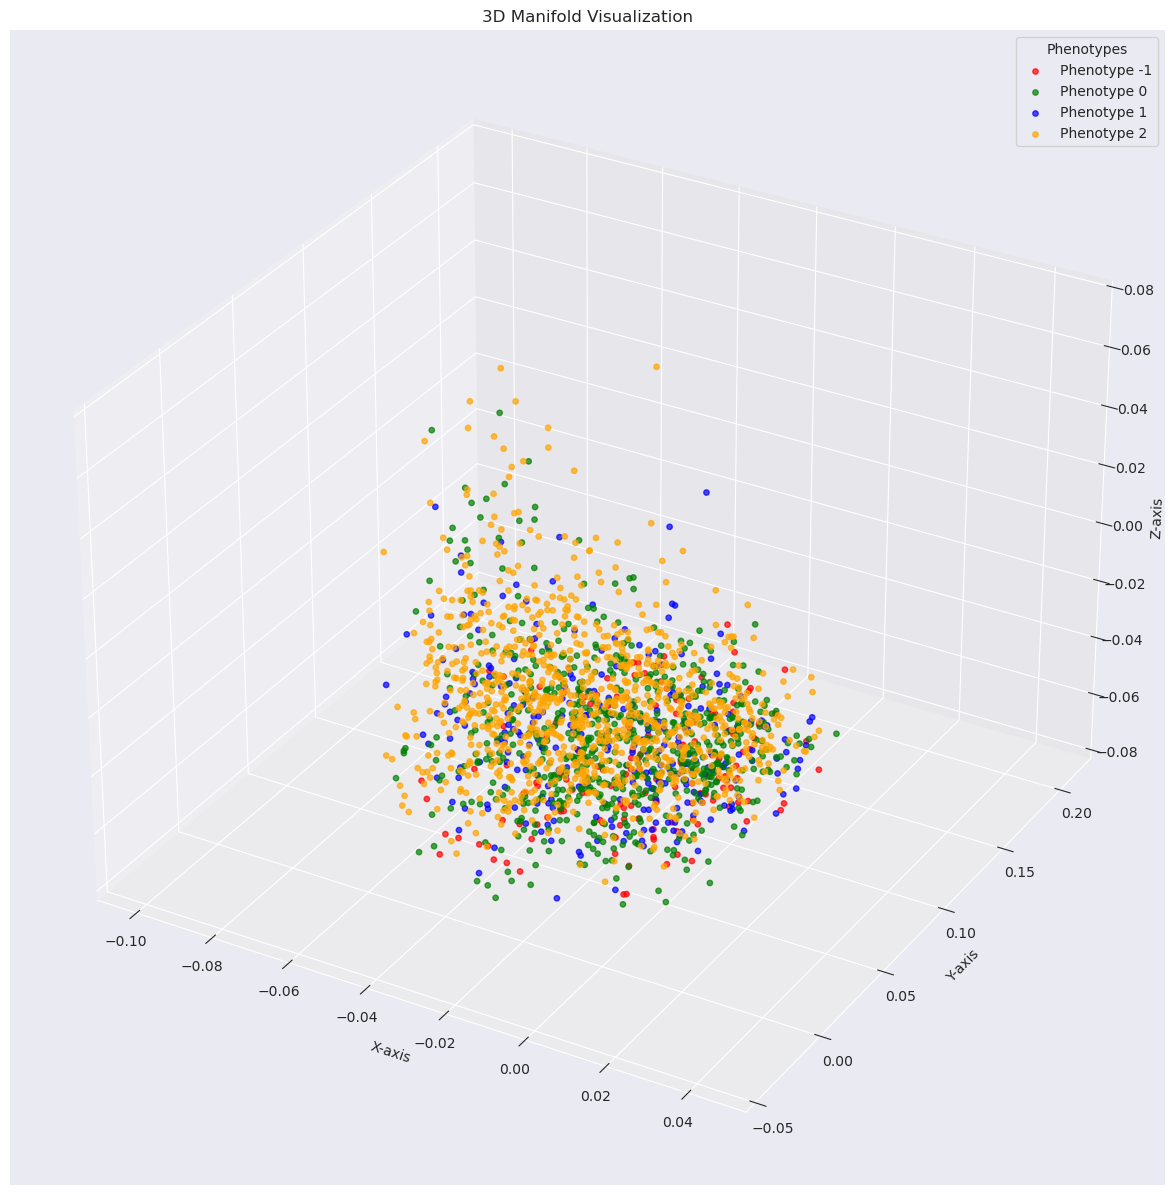

In [94]:
# Generating a Distinct Manifold using P1
X = SPIROMICS_dataset_P1.loc[:, SPIROMICS_dataset_P1.columns.str.startswith('X')]
X = X[['X8464_31', 'X5691_2', 'X12549_33', 'X21112_6', 'X8885_6', 'X14097_86', 'X21685_29', 'X13731_14', 'X2974_61', 'X13722_105', 'X17346_61', 'X16818_200', 'X18882_7', 'X3485_28', 'X11388_75', 'X6260_14', 'X5124_62', 'X4811_33', 'X4496_60', 'X9793_145', 'X2637_77', 'X14116_129', 'X15559_5', 'X5738_25', 'X2960_66']]
Y = SPIROMICS_dataset_P1['GOLD_STAGE_COPD_SEVERITY']
Y_combined_classes = Y.replace(2, 1)
Y_combined_classes = Y.replace([3, 4], 2)

# Predefined colors for phenotypes
predefined_colors = ['red', 'green', 'blue', 'orange']  # Assign unique colors for [-1, 0, 1, 2]
unique_phenotypes = sorted(Y_combined_classes.unique())
phenotype_to_color = {phenotype: color for phenotype, color in zip(unique_phenotypes, predefined_colors)}

# Apply LLE
# 45 Neighbors
lle = LocallyLinearEmbedding(n_components=3, n_neighbors=45, reg=0.0036638517289616286, max_iter=300, random_state=42)
manifold = lle.fit_transform(X)

# Convert manifold to a DataFrame
manifold_df = pd.DataFrame(manifold, columns=['X', 'Y', 'Z'])
manifold_df['phenotype'] = Y_combined_classes.values
manifold_df['color'] = manifold_df['phenotype'].map(phenotype_to_color)

# Create a 3D scatter plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Plot each phenotype with its predefined color
for phenotype, color in phenotype_to_color.items():
    phenotype_data = manifold_df[manifold_df['phenotype'] == phenotype]
    ax.scatter(phenotype_data['X'], phenotype_data['Y'], phenotype_data['Z'],
               color=color, label=f'Phenotype {phenotype}', s=15, alpha=0.7)

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Manifold Visualization')

# Add legend
ax.legend(title='Phenotypes', loc='upper right')

# Show the plot
plt.show()

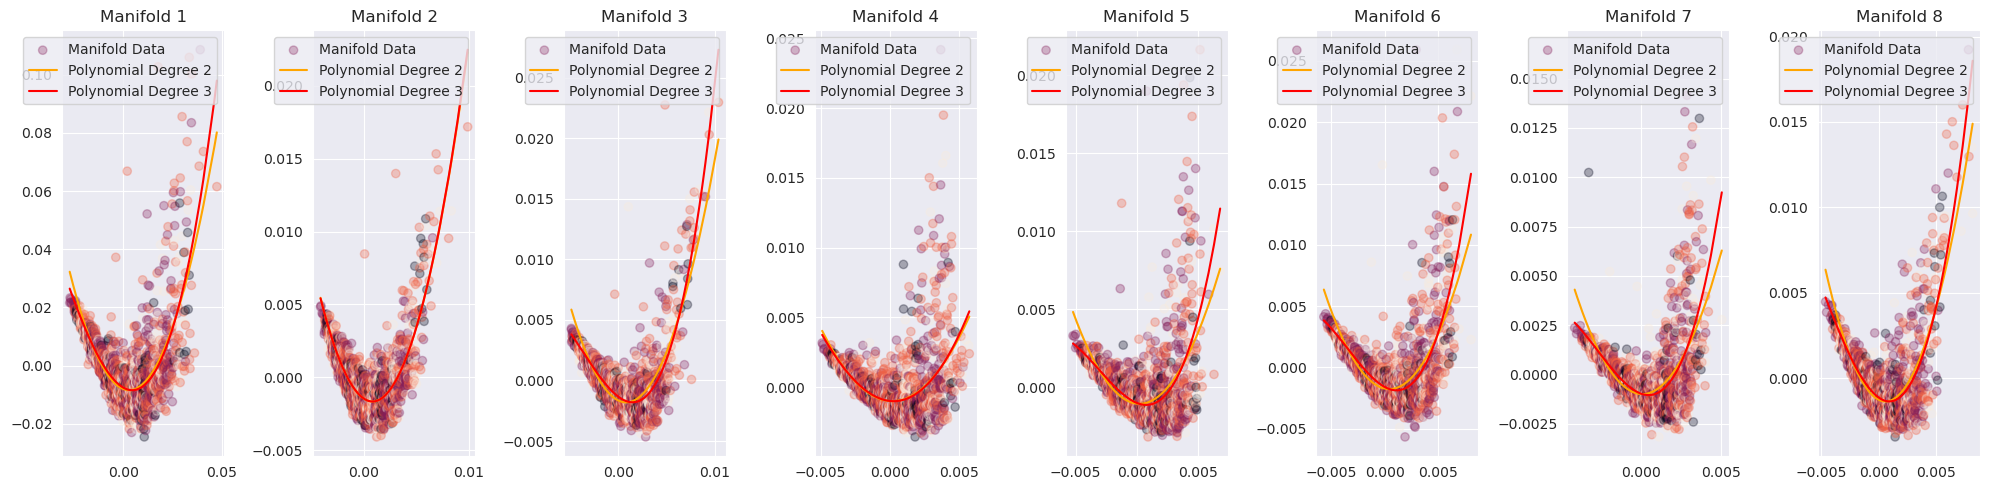

In [303]:
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures


###########################################################
#        MANIFOLD STABILITY WITHIN THE SAME VISIT         #
###########################################################

# Function to calculate pairwise distance preservation
def calculate_distance_preservation(original_data, manifold_data):
    original_distances = pairwise_distances(original_data)
    manifold_distances = pairwise_distances(manifold_data)
    correlation = np.corrcoef(original_distances.flatten(), manifold_distances.flatten())[0, 1]
    return correlation

# Function to calculate neighborhood preservation
def calculate_neighborhood_preservation(original_data, manifold_data, n_neighbors=10):
    original_neighbors = np.argsort(pairwise_distances(original_data), axis=1)[:, 1:n_neighbors+1]
    manifold_neighbors = np.argsort(pairwise_distances(manifold_data), axis=1)[:, 1:n_neighbors+1]
    intersection_count = 0
    for i in range(original_neighbors.shape[0]):
        intersection_count += len(set(original_neighbors[i]).intersection(set(manifold_neighbors[i])))
    return intersection_count / (original_neighbors.shape[0] * n_neighbors)

# Cross-Validation for Manifold Learning
def manifold_cross_validation(dataset, n_splits=3, n_components=3, n_neighbors=10):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    manifolds_x = []
    manifolds_y = []
    manifolds = []
    metrics = []
    X = dataset.loc[:, dataset.columns.str.startswith('X')]
    Y = dataset['GOLD_STAGE_COPD_SEVERITY']


    for train_index, test_index in kf.split(X, Y):
        x_train = X.iloc[train_index]
        y_train = Y.iloc[train_index]
        Y_train_combined_classes = y_train.replace(2, 1)
        Y_train_combined_classes = Y_train_combined_classes.replace([3, 4], 2)
        # Apply LLE
        # lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors,  eigen_solver='dense')
        lle = LocallyLinearEmbedding(n_components=3, n_neighbors=45, reg=0.0036638517289616286, max_iter=300, random_state=42)

        manifold = lle.fit_transform(x_train)
        # ###############################################
        # # Access the nearest neighbors model
        # nbrs_model = lle.nbrs_
        #
        # # Generate the sparse KNN graph
        # knn_graph_sparse = nbrs_model.kneighbors_graph(x_train, mode='connectivity')  # 'connectivity' or 'distance'
        # print(knn_graph_sparse.shape)
        # # print(knn_graph_sparse)
        # # Convert the sparse graph to a NetworkX graph
        # knn_graph = nx.from_numpy_array(knn_graph_sparse)
        #
        # # Visualize the graph
        # plt.figure(figsize=(10, 10))
        # nx.draw(knn_graph, node_size=20, node_color="blue", with_labels=False)
        # plt.title("KNN Graph Extracted from LLE (nbrs_)")
        # plt.show()
        # ############################33

        manifolds.append(manifold)

        # Quantitative Metrics
        reconstruction_error = lle.reconstruction_error_
        distance_preservation = calculate_distance_preservation(x_train, manifold)
        neighborhood_preservation = calculate_neighborhood_preservation(x_train, manifold, n_neighbors)
        metrics.append({
            "Reconstruction Error": reconstruction_error,
            "Distance Preservation": distance_preservation,
            "Neighborhood Preservation": neighborhood_preservation
        })
        manifolds_x.append(x_train)
        manifolds_y.append(Y_train_combined_classes)
    return manifolds_x, manifolds_y, manifolds, metrics

# Run Cross-Validation
manifolds_x, manifolds_y, manifolds, metrics = manifold_cross_validation(SPIROMICS_dataset_P1, n_splits=8, n_components=3, n_neighbors=150)
# # Print Metrics
# for i, metric in enumerate(metrics):
#     print(f"Split {i+1}:")
#     print(f"  Reconstruction Error: {metric['Reconstruction Error']:.4f}")
#     print(f"  Distance Preservation: {metric['Distance Preservation']:.4f}")
#     print(f"  Neighborhood Preservation: {metric['Neighborhood Preservation']:.4f}")
# Store metrics in DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.index = [f"Split {i+1}" for i in range(len(metrics))]
# print(metrics_df)


from scipy.spatial import procrustes

import numpy as np

# Function to perform Procrustes Analysis
def align_manifolds(reference, manifold):
    """
    Aligns a manifold to the reference manifold using Procrustes Analysis.
    Returns the aligned manifold and the Procrustes similarity score.
    """
    mtx1, mtx2, disparity = procrustes(reference, manifold)
    return mtx2, 1 - disparity  # Return aligned manifold and similarity score

# Align all manifolds to the first one (as reference)
reference_manifold = manifolds[0]
aligned_manifolds = []
similarity_scores = []


for i, manifold in enumerate(manifolds):
    # print(reference_manifold.shape)
    # print(manifold.shape)
    min_length = min(reference_manifold.shape[0], manifold.shape[0])
    reference_manifold = reference_manifold[:min_length]
    manifold = manifold[:min_length]


    aligned, similarity = align_manifolds(reference_manifold, manifold)
    aligned_manifolds.append(aligned)
    similarity_scores.append(similarity)
    # print(f"Manifold {i+1} aligned to reference with similarity score: {similarity:.4f}")


#
# # Average similarity score
# average_similarity = np.mean(similarity_scores)
# print(f"Average Procrustes Similarity Score: {average_similarity:.4f}")
#


# # Qualitative comparison - visualize manifolds
# fig, axes = plt.subplots(1, len(manifolds), figsize=(10, 10))
# for i, manifold in enumerate(manifolds):
#     axes[i].scatter(manifold[:, 0], manifold[:, 1], c=manifolds_y[i], cmap='viridis', s=10)
#     axes[i].set_title(f"Manifold Split {i+1}")
# plt.tight_layout()
# plt.show()


# # Visualize the aligned manifolds
# fig, axes = plt.subplots(1, len(aligned_manifolds), figsize=(20, 5))
# for i, aligned_manifold in enumerate(aligned_manifolds):
#     # Ensure the sizes match by truncating the longer array
#     min_length = min(aligned_manifold.shape[0], len(manifolds_y[i]))
#     aligned_manifold = aligned_manifold[:min_length]
#     manifold_y = manifolds_y[i][:min_length]
#     axes[i].scatter(aligned_manifold[:, 0], aligned_manifold[:, 1], c=manifold_y, cmap='viridis', s=10)
#     axes[i].set_title(f"Manifold {i+1}")
# plt.tight_layout()
# plt.show()




# Fit Polynomial Regression and Spline Fit
def fit_polynomial(x, y, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return model, poly, r2, rmse, y_pred

def fit_spline(x, y, smoothing_factor=0.01):
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    spline = UnivariateSpline(x_sorted, y_sorted, s=smoothing_factor)
    y_spline = spline(x_sorted)
    rmse = np.sqrt(mean_squared_error(y_sorted, y_spline))
    return spline, rmse, y_spline

fig, axes = plt.subplots(1, len(aligned_manifolds), figsize=(20, 5))

for i, aligned_manifold in enumerate(aligned_manifolds):

    min_length = min(aligned_manifold.shape[0], len(manifolds_y[i]))
    aligned_manifold = aligned_manifold[:min_length]
    manifold_y = manifolds_y[i][:min_length]

    x_vals = aligned_manifold[:, 0]
    y_vals = aligned_manifold[:, 1]
    # Sort x-values and corresponding y-values to ensure smooth polynomial fit
    sorted_indices = np.argsort(x_vals)
    x_sorted = x_vals[sorted_indices]
    y_sorted = y_vals[sorted_indices]

    poly2_model, _, r2_poly2, rmse_poly2, y_poly2 = fit_polynomial(x_sorted, y_sorted, degree=2)
    poly3_model, _, r2_poly3, rmse_poly3, y_poly3 = fit_polynomial(x_sorted, y_sorted, degree=3)
    spline_model, rmse_spline, y_spline = fit_spline(x_sorted, y_sorted, smoothing_factor=0.001)

    axes[i].scatter(x_sorted, y_sorted, c=manifold_y, alpha=0.3, label="Manifold Data")
    axes[i].plot(x_sorted, y_poly2, color='orange', label="Polynomial Degree 2")
    axes[i].plot(x_sorted, y_poly3, color='red', label="Polynomial Degree 3")
    # axes[i].plot(x_sorted, y_spline, color='green', linestyle='dashed', label="Spline Fit")
    axes[i].set_title(f"Manifold {i+1}")
    axes[i].legend()


plt.tight_layout()
plt.show()


/tmp/ipykernel_5282/3025218733.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


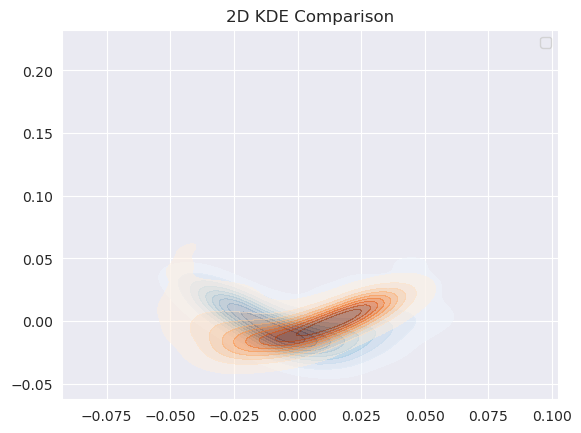

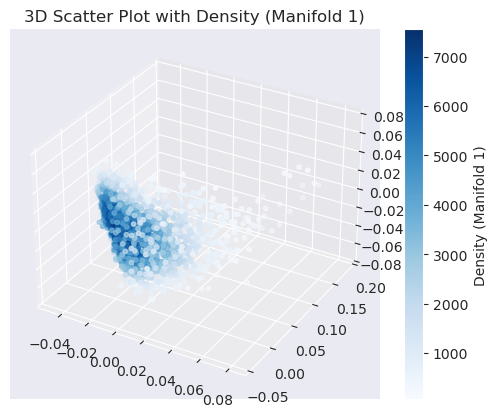

KL Divergence: inf
Earth Mover's Distance: 0.001453937158817145


In [90]:
import seaborn as sns

# Example: 2D data
manifold1 = manifolds[0]
manifold2 = manifolds[2]

# Plot KDE for each manifold
sns.kdeplot(x=manifold1[:, 0], y=manifold1[:, 1], fill=True, cmap="Blues", label="Manifold 1", alpha=0.5)
sns.kdeplot(x=manifold2[:, 0], y=manifold2[:, 1], fill=True, cmap="Oranges", label="Manifold 2", alpha=0.5)
plt.legend()
plt.title("2D KDE Comparison")
plt.show()

import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example: 3D data for two manifolds
np.random.seed(42)
# KDE for manifold 1 and 2
kde1 = gaussian_kde(manifold1.T)  # Transpose for (features, samples)
kde2 = gaussian_kde(manifold2.T)

# Define a 3D grid for evaluation
x, y, z = np.linspace(-3, 4, 50), np.linspace(-3, 4, 50), np.linspace(-3, 4, 50)
xv, yv, zv = np.meshgrid(x, y, z)
grid_coords = np.vstack([xv.ravel(), yv.ravel(), zv.ravel()])

# Evaluate the KDEs on the grid
density1 = kde1(grid_coords).reshape(xv.shape)
density2 = kde2(grid_coords).reshape(xv.shape)



# Evaluate KDE for scatter plot visualization
density1_points = kde1(manifold1.T)
density2_points = kde2(manifold2.T)

# 3D Scatter plot for Manifold 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(manifold1[:, 0], manifold1[:, 1], manifold1[:, 2], c=density1_points, cmap='Blues', s=10)
plt.colorbar(sc, label="Density (Manifold 1)")
plt.title("3D Scatter Plot with Density (Manifold 1)")
plt.show()

from scipy.stats import entropy

# Flatten the densities for comparison
density1_flat = density1.ravel()
density2_flat = density2.ravel()

# Normalize densities
density1_flat /= density1_flat.sum()
density2_flat /= density2_flat.sum()

# Compute KL Divergence
kl_div = entropy(density1_flat, density2_flat)
print(f"KL Divergence: {kl_div}")

from scipy.stats import wasserstein_distance

# Compare point clouds directly
emd = wasserstein_distance(manifold1.ravel(), manifold2.ravel())
print(f"Earth Mover's Distance: {emd}")



In [128]:
from sklearn.utils import resample

def stratified_oversample(X, Y, target_size):
    """
    Oversamples the dataset to the target size while preserving class distribution.
    """
    # Combine X and Y for oversampling
    data = pd.concat([X, Y], axis=1)
    oversampled_data = data.groupby(Y.name, group_keys=False).apply(
        lambda x: x.sample(int(target_size * len(x) / len(data)), replace=True, random_state=42)
    )
    return oversampled_data.iloc[:, :-1], oversampled_data.iloc[:, -1]

# Oversample Visit 2 to match Visit 1 size
X2, Y2 = SPIROMICS_dataset_P2.loc[:, SPIROMICS_dataset_P2.columns.str.startswith('X')], SPIROMICS_dataset_P2['GOLD_STAGE_COPD_SEVERITY']
X2_oversampled, Y2_oversampled = stratified_oversample(X2, Y2, len(SPIROMICS_dataset_P1))

SPIROMICS_datasets_1 = [
    pd.concat([X1, Y1], axis=1),  # Original Visit 1 data
    pd.concat([X2_oversampled, Y2_oversampled], axis=1)  # Oversampled Visit 2 data
]

/tmp/ipykernel_5282/1565626169.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  oversampled_data = data.groupby(Y.name, group_keys=False).apply(


Reconstruction Error: 0.0081
Neighborhood Preservation Score: 0.0471
Pairwise Distance Preservation Score: 0.5165
Reconstruction Error: 0.0107
Neighborhood Preservation Score: 0.0554
Pairwise Distance Preservation Score: 0.5735


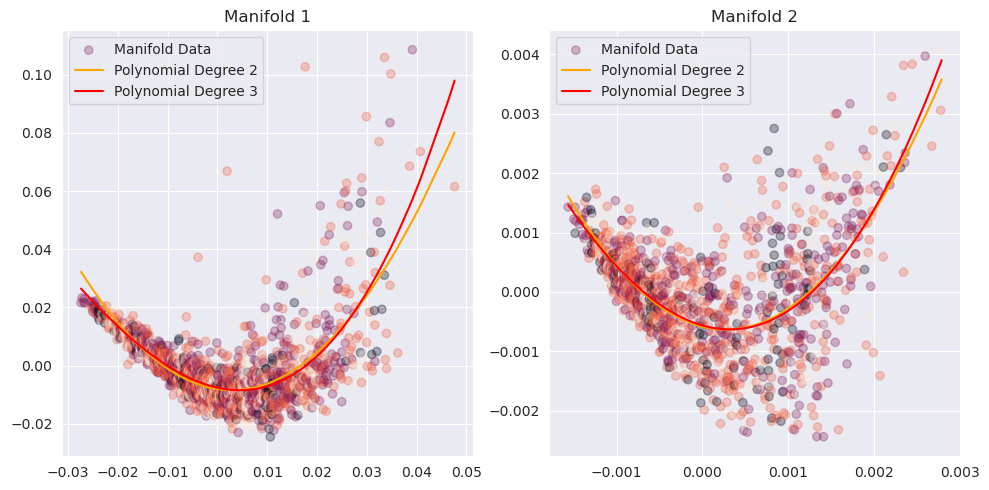

In [305]:
####################################################
#        MANIFOLD STABILITY BETWEEN VISITS         #
####################################################
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd


# Function to Generate and Evaluate Manifold
def generate_manifold(dataset, visit_num, n_neighbors=300, n_components=3, reg=0.01):

    # print(f"\n--- Generating Manifold for Visit {visit_num} ---")
    # Feature selection based on correlation
    X = dataset.loc[:, dataset.columns.str.startswith('X')]
    Y = dataset['GOLD_STAGE_COPD_SEVERITY']
    Y_combined_classes = Y.replace(2, 1)
    Y_combined_classes = Y_combined_classes.replace([3, 4], 2)



    kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X, Y):
        x_train = X.iloc[train_index]
        # print(x_train.shape)
        y_train = Y.iloc[train_index]
        Y_train_combined_classes = y_train.replace(2, 1)

        Y_train_combined_classes = Y_train_combined_classes.replace([3, 4], 2)
        # print(Y_train_combined_classes.value_counts(normalize=True))
        # Apply LLE
        break
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, reg=reg, max_iter=300, random_state=42)

    embedding = lle.fit_transform(x_train)


    # Evaluate the manifold
    reconstruction_error = lle.reconstruction_error_
    neighborhood_preservation_score = calculate_neighborhood_preservation(x_train, embedding)
    pairwise_distances_preservation_score = calculate_distance_preservation(x_train, embedding)

    print("Reconstruction Error: %.4f" % reconstruction_error)
    print("Neighborhood Preservation Score: %.4f" % neighborhood_preservation_score)
    print("Pairwise Distance Preservation Score: %.4f" % pairwise_distances_preservation_score)

    # # 3D Scatter Plot
    # fig = plt.figure(figsize=(12, 10))
    # ax = fig.add_subplot(111, projection='3d')
    # custom_cmap = ListedColormap(['#A02B93', '#196B24', '#E97132', '#6E2D0C'])  # Custom colors
    # sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=Y_train_combined_classes, s=5, alpha=0.7, cmap=custom_cmap)
    #
    # # Add legend
    # legend1 = ax.legend(*sc.legend_elements(), loc="upper center", title="GOLD", ncol=4)
    # ax.add_artist(legend1)
    #
    # # Hide grid and axes for cleaner plot
    # ax.grid(False)
    # ax.set_axis_off()
    # fig.patch.set_alpha(0.0)
    #
    # plt.title(f"3D LLE Manifold for Visit {visit_num}")
    # plt.show()
    return x_train, Y_train_combined_classes, embedding


SPIROMICS_datasets = [SPIROMICS_dataset_P1, SPIROMICS_dataset_P2]
manifolds = []
manifolds_x = []
manifolds_y = []
# Generate Manifolds for Visit 1, 2, and 3
for idx, SPIROMICS_dataset_ in enumerate(SPIROMICS_datasets):
    if idx == 0:
        x, y, manifold = generate_manifold(SPIROMICS_dataset_, visit_num=idx, n_components=3, n_neighbors=45, reg=0.0036638517289616286)
    else:
        x, y, manifold = generate_manifold(SPIROMICS_dataset_, visit_num=idx, n_components=3, n_neighbors=50, reg=0.0036638517289616286)
    manifolds.append(manifold)
    manifolds_x.append(x)
    manifolds_y.append(y)



# Align all manifolds to the first one (as reference)
reference_manifold = manifolds[0]
aligned_manifolds = []
similarity_scores = []


for i, manifold in enumerate(manifolds):
    # print(reference_manifold.shape)
    # print(manifold.shape)
    min_length = min(reference_manifold.shape[0], manifold.shape[0])
    reference_manifold = reference_manifold[:min_length]
    manifold = manifold[:min_length]


    aligned, similarity = align_manifolds(reference_manifold, manifold)
    aligned_manifolds.append(aligned)
    similarity_scores.append(similarity)
    # print(f"Manifold {i+1} aligned to reference with similarity score: {similarity:.4f}")

# # Qualitative comparison - visualize manifolds
# fig, axes = plt.subplots(1, len(manifolds), figsize=(10, 10))
# for i, manifold in enumerate(manifolds):
#     axes[i].scatter(manifold[:, 0], manifold[:, 1], c=manifolds_y[i], cmap='viridis', s=10)
#     axes[i].set_title(f"Manifold Split {i+1}")
# plt.tight_layout()
# plt.show()

# Visualize the aligned manifolds
fig, axes = plt.subplots(1, len(aligned_manifolds), figsize=(10, 5))
for i, aligned_manifold in enumerate(aligned_manifolds):
    # Ensure the sizes match by truncating the longer array
    min_length = min(aligned_manifold.shape[0], len(manifolds_y[i]))
    aligned_manifold = aligned_manifold[:min_length]
    manifold_y = manifolds_y[i][:min_length]

    x_vals = aligned_manifold[:, 0]
    y_vals = aligned_manifold[:, 1]
    # Sort x-values and corresponding y-values to ensure smooth polynomial fit
    sorted_indices = np.argsort(x_vals)
    x_sorted = x_vals[sorted_indices]
    y_sorted = y_vals[sorted_indices]

    poly2_model, _, r2_poly2, rmse_poly2, y_poly2 = fit_polynomial(x_sorted, y_sorted, degree=2)
    poly3_model, _, r2_poly3, rmse_poly3, y_poly3 = fit_polynomial(x_sorted, y_sorted, degree=3)
    # spline_model, rmse_spline, y_spline = fit_spline(x_sorted, y_sorted, smoothing_factor=0.001)

    axes[i].scatter(x_sorted, y_sorted, c=manifold_y, alpha=0.3, label="Manifold Data")
    axes[i].plot(x_sorted, y_poly2, color='orange', label="Polynomial Degree 2")
    axes[i].plot(x_sorted, y_poly3, color='red', label="Polynomial Degree 3")
    # axes[i].plot(x_sorted, y_spline, color='green', linestyle='dashed', label="Spline Fit")
    axes[i].set_title(f"Manifold {i+1}")
    axes[i].legend()

plt.tight_layout()
plt.show()







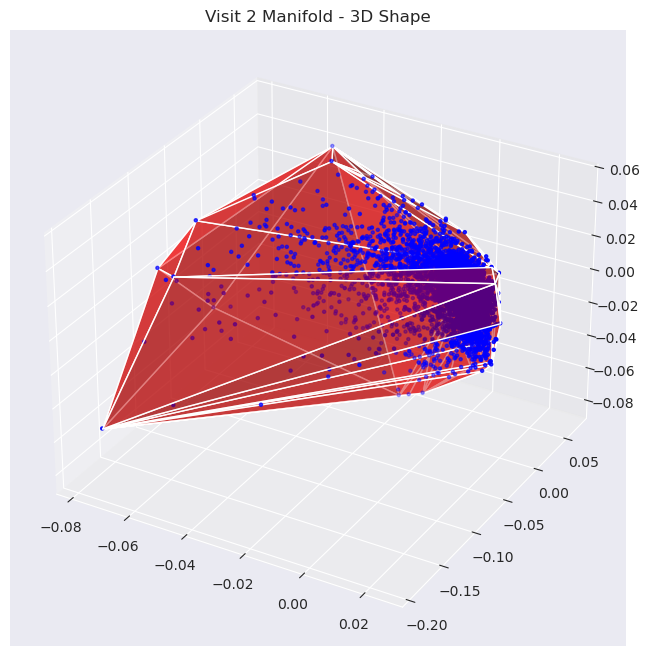

Volume of Visit 1 Manifold: 0.0014
Volume of Visit 2 Manifold: 0.0009
Volume Difference: 0.0005


In [234]:
import numpy as np
import matplotlib.pyplot as plt
import alphashape
from scipy.spatial import ConvexHull
import trimesh

def plot_alpha_shape_2d(points, alpha=0.1, title="Manifold Shape"):
    """Creates a 2D Alpha Shape to Enclose the Manifold"""
    alpha_shape = alphashape.alphashape(points, alpha)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(points[:, 0], points[:, 1], color="blue", s=5, label="Manifold Points")

    # Plot Alpha Shape boundary
    for simplex in alpha_shape.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'r-', linewidth=1)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

def plot_alpha_shape_3d(points, alpha=0.1, title="3D Manifold Shape"):
    """Creates a 3D Alpha Shape (Concave Hull)"""
    mesh = alphashape.alphashape(points, alpha)  # This returns a Trimesh object

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot manifold points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color="blue", s=5, label="Manifold Points")

    # Extract faces from Trimesh and plot
    if isinstance(mesh, trimesh.Trimesh):
        for face in mesh.faces:
            face_vertices = mesh.vertices[face]
            ax.plot_trisurf(face_vertices[:, 0], face_vertices[:, 1], face_vertices[:, 2], color="red", alpha=0.5)

    plt.title(title)
    plt.show()

def compute_volume(points):
    """Computes the enclosed volume of a manifold using Convex Hull"""
    hull = ConvexHull(points)
    return hull.volume
visit1 = manifolds[0]
visit2 = manifolds[1]
# Plot Alpha Shapes for 2D or 3D Manifold
if visit1.shape[1] == 2:
    plot_alpha_shape_2d(visit1, alpha=0.1, title="Visit 1 Manifold - Shape")
    plot_alpha_shape_2d(visit2, alpha=0.1, title="Visit 2 Manifold - Shape")
elif visit1.shape[1] == 3:
    plot_alpha_shape_3d(visit1, alpha=0.1, title="Visit 1 Manifold - 3D Shape")
    plot_alpha_shape_3d(visit2, alpha=0.1, title="Visit 2 Manifold - 3D Shape")

# Compute & Compare Volume
volume_visit1 = compute_volume(visit1)
volume_visit2 = compute_volume(visit2)

print(f"Volume of Visit 1 Manifold: {volume_visit1:.4f}")
print(f"Volume of Visit 2 Manifold: {volume_visit2:.4f}")
print(f"Volume Difference: {abs(volume_visit1 - volume_visit2):.4f}")


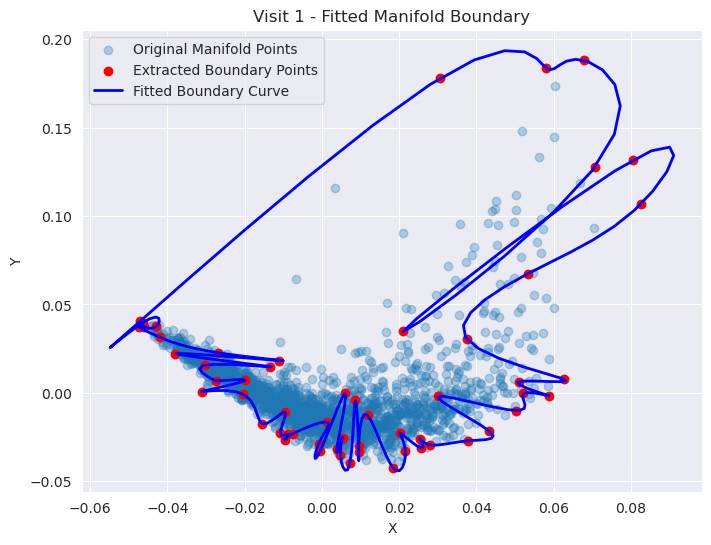

In [246]:

visit1 = manifolds[0]
visit2 = manifolds[1]
import numpy as np
import matplotlib.pyplot as plt
import alphashape
import scipy.interpolate as interpolate
from scipy.spatial import ConvexHull

def extract_boundary_points(points, alpha=0.9):
    """Extracts boundary points using Convex Hull as a fallback if Alpha Shape fails."""

    # Step 1: Get Convex Hull as a backup boundary
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    # Step 2: Try extracting refined boundary with Alpha Shape
    alpha_shape = alphashape.alphashape(points, alpha)

    if alpha_shape is not None and hasattr(alpha_shape, "vertices"):
        boundary_indices = np.unique(np.array(alpha_shape.vertices, dtype=int))
        refined_boundary_points = points[boundary_indices]

        # Ensure we have enough points, otherwise fallback to Convex Hull
        if len(refined_boundary_points) >= 5:
            return refined_boundary_points

    print("Warning: Using Convex Hull as fallback for boundary extraction.")
    return hull_points

def fit_boundary_curve(boundary_points, num_fit_points=300):
    """Fits a smooth curve through the boundary points using splines."""
    if boundary_points is None or len(boundary_points) < 5:
        return None, None  # Return empty if not enough points

    # Sort points by angle from the centroid (ensuring a continuous path)
    centroid = np.mean(boundary_points, axis=0)
    angles = np.arctan2(boundary_points[:, 1] - centroid[1], boundary_points[:, 0] - centroid[0])
    sorted_indices = np.argsort(angles)
    boundary_points = boundary_points[sorted_indices]

    # Close the loop by adding the first point at the end
    boundary_points = np.vstack([boundary_points, boundary_points[0]])

    # Parameterize the boundary points
    t = np.linspace(0, 1, len(boundary_points))

    # Fit cubic splines
    spline_x = interpolate.CubicSpline(t, boundary_points[:, 0], bc_type="clamped")  # Changed from 'periodic'
    spline_y = interpolate.CubicSpline(t, boundary_points[:, 1], bc_type="clamped")  # Changed from 'periodic'

    # Generate smooth fitted boundary
    t_fine = np.linspace(0, 1, num_fit_points)
    smooth_x = spline_x(t_fine)
    smooth_y = spline_y(t_fine)

    return smooth_x, smooth_y

def plot_fitted_boundary(points, alpha=0.1, title="Fitted Manifold Boundary"):
    """Plots the original manifold points and the fitted boundary."""
    boundary_points = extract_boundary_points(points, alpha)

    if boundary_points is None or len(boundary_points) < 5:
        print(f"Skipping {title} - Not enough boundary points detected.")
        return

    smooth_x, smooth_y = fit_boundary_curve(boundary_points)

    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], alpha=0.3, label="Original Manifold Points")
    plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color="red", label="Extracted Boundary Points")

    if smooth_x is not None and smooth_y is not None:
        plt.plot(smooth_x, smooth_y, color="blue", linewidth=2, label="Fitted Boundary Curve")

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

# Apply to Visit 1 and Visit 2 Manifolds
plot_fitted_boundary(visit1, alpha=0.1, title="Visit 1 - Fitted Manifold Boundary")
plot_fitted_boundary(visit2, alpha=0.1, title="Visit 2 - Fitted Manifold Boundary")



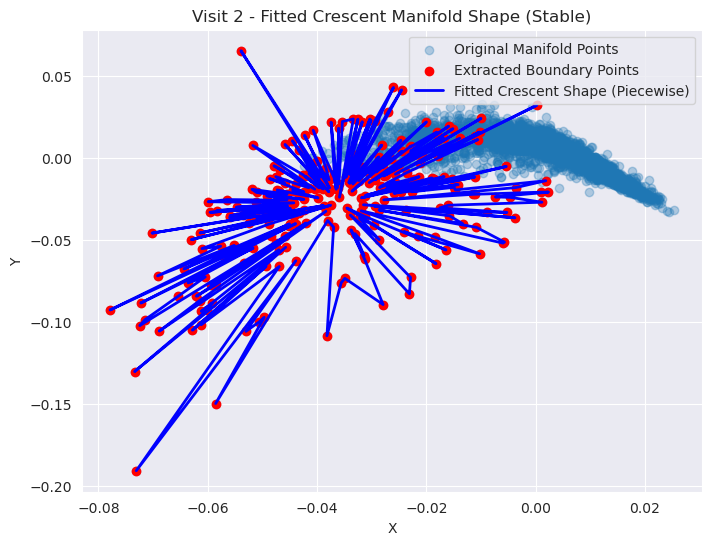

In [265]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN

def extract_boundary_points(points, eps=0.009, min_samples=20):
    """Extract boundary points using DBSCAN for density filtering."""
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    boundary_mask = clustering.labels_ == -1  # -1 means outlier (potential boundary)
    boundary_points = points[boundary_mask]

    if len(boundary_points) < 5:
        print("Warning: Not enough boundary points detected.")
        return None

    return boundary_points

def plot_crescent_shape_stable(points, title="Fitted Crescent Manifold Shape"):
    """Plots the original manifold points and the estimated crescent boundary using piecewise linear fitting."""
    boundary_points = extract_boundary_points(points)

    if boundary_points is None:
        print(f"Skipping {title} - Not enough boundary points detected.")
        return

    # Sort boundary points by angle around the centroid
    centroid = np.mean(boundary_points, axis=0)
    angles = np.arctan2(boundary_points[:, 1] - centroid[1], boundary_points[:, 0] - centroid[0])
    sorted_indices = np.argsort(angles)
    sorted_boundary = boundary_points[sorted_indices]

    # Close the loop by appending the first point to the end
    sorted_boundary = np.vstack([sorted_boundary, sorted_boundary[0]])

    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], alpha=0.3, label="Original Manifold Points")
    plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color="red", label="Extracted Boundary Points")
    plt.plot(sorted_boundary[:, 0], sorted_boundary[:, 1], color="blue", linewidth=2, label="Fitted Crescent Shape (Piecewise)")

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

# Apply to Visit 1 and Visit 2 Manifolds
plot_crescent_shape_stable(visit1, title="Visit 1 - Fitted Crescent Manifold Shape (Stable)")
plot_crescent_shape_stable(visit2, title="Visit 2 - Fitted Crescent Manifold Shape (Stable)")


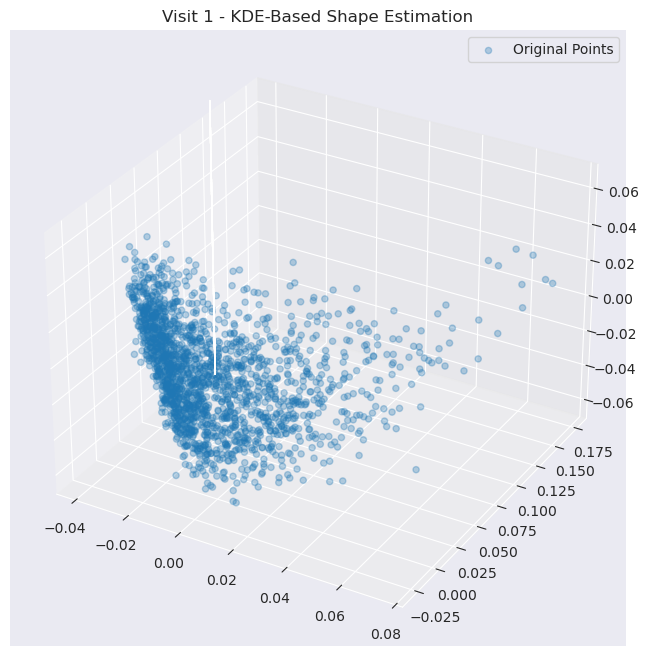

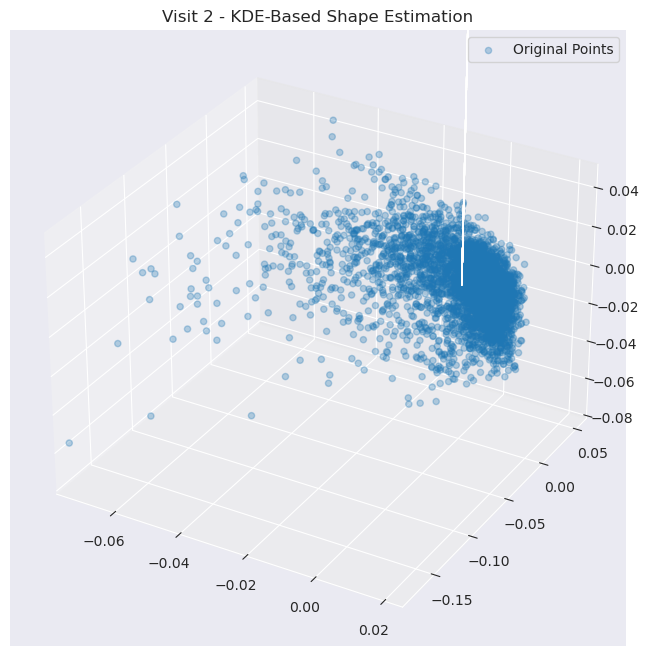

In [283]:
from sklearn.neighbors import KernelDensity
from skimage.measure import marching_cubes
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def estimate_kde_boundary(points, bandwidth=0.02, density_threshold=0.05):
    """Estimate the shape of a dataset using KDE and iso-density contours."""
    dim = points.shape[1]

    # 2D KDE
    if dim == 2:
        kde = KernelDensity(bandwidth=bandwidth, kernel="gaussian").fit(points)

        # Create a grid for KDE evaluation
        x_min, x_max = points[:, 0].min(), points[:, 0].max()
        y_min, y_max = points[:, 1].min(), points[:, 1].max()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        # Evaluate density on the grid
        log_density = kde.score_samples(grid_points)
        density = np.exp(log_density).reshape(xx.shape)

        return xx, yy, density

    # 3D KDE
    elif dim == 3:
        kde = KernelDensity(bandwidth=bandwidth, kernel="gaussian").fit(points)

        # Create a grid for KDE evaluation
        x_min, x_max = points[:, 0].min(), points[:, 0].max()
        y_min, y_max = points[:, 1].min(), points[:, 1].max()
        z_min, z_max = points[:, 2].min(), points[:, 2].max()
        xx, yy, zz = np.meshgrid(
            np.linspace(x_min, x_max, 50),
            np.linspace(y_min, y_max, 50),
            np.linspace(z_min, z_max, 50),
        )
        grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

        # Evaluate density on the grid
        log_density = kde.score_samples(grid_points)
        density = np.exp(log_density).reshape(xx.shape)

        return xx, yy, zz, density

def plot_kde_shape(points, bandwidth=0.02, density_threshold=0.05, title="KDE-Based Shape Estimation"):
    """Plots the KDE-based shape estimation for 2D or 3D data."""
    dim = points.shape[1]

    if dim == 2:
        xx, yy, density = estimate_kde_boundary(points, bandwidth, density_threshold)

        plt.figure(figsize=(8, 6))
        plt.contourf(xx, yy, density, levels=50, cmap="Blues", alpha=0.7)
        plt.scatter(points[:, 0], points[:, 1], alpha=0.3, label="Original Points")
        plt.contour(xx, yy, density, levels=[density_threshold], colors="red", label="Boundary")
        plt.title(title)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.show()

    elif dim == 3:
        xx, yy, zz, density = estimate_kde_boundary(points, bandwidth, density_threshold)

        # Extract isosurface using marching cubes
        verts, faces, _, _ = marching_cubes(density, level=density_threshold, spacing=(xx[1, 0, 0] - xx[0, 0, 0],
                                                                                       yy[0, 1, 0] - yy[0, 0, 0],
                                                                                       zz[0, 0, 1] - zz[0, 0, 0]))

        # Plot the isosurface
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], alpha=0.3, label="Original Points")
        mesh = Poly3DCollection(verts[faces], alpha=0.7, facecolor="red")
        ax.add_collection3d(mesh)

        # Set plot limits
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_zlim(zz.min(), zz.max())

        plt.title(title)
        plt.legend()
        plt.show()

# Apply to Visit 1 and Visit 2 Manifolds
plot_kde_shape(visit1, bandwidth=0.02, density_threshold=0.01, title="Visit 1 - KDE-Based Shape Estimation")
plot_kde_shape(visit2, bandwidth=0.02, density_threshold=0.01, title="Visit 2 - KDE-Based Shape Estimation")


In [ ]:
# Regression Techniques - Multi-Linear Regression for estimating the shape and potentially non-linear.
# Interpolation - Identifying trends in the data, not trying to contain the points.

# For eath mover's - try to unpack it so that you can see values for each point. for common subjects we want to see distances between manifolds.
# For eath mover's - try to unpack it so that you can see values for each point. for common subjects we want to see distances between manifolds.

In [286]:
import numpy as np
import ot

def compute_emd(point_cloud_1, point_cloud_2):
    """
    Computes Earth Mover's Distance (EMD) between two point clouds.

    Args:
        point_cloud_1 (numpy.ndarray): First point cloud of shape (n1, d).
        point_cloud_2 (numpy.ndarray): Second point cloud of shape (n2, d).

    Returns:
        float: The Earth Mover's Distance between the two point clouds.
    """
    # Ensure both point clouds have the same dimensionality
    assert point_cloud_1.shape[1] == point_cloud_2.shape[1], "Point clouds must have the same dimensionality."

    # Create uniform weights for both point clouds
    weights_1 = np.ones(len(point_cloud_1)) / len(point_cloud_1)
    weights_2 = np.ones(len(point_cloud_2)) / len(point_cloud_2)

    # Compute the cost matrix (pairwise distances between points)
    cost_matrix = np.linalg.norm(point_cloud_1[:, None, :] - point_cloud_2[None, :, :], axis=2)

    # Solve the optimal transport problem (EMD)
    emd_value = ot.emd2(weights_1, weights_2, cost_matrix)
    flow_matrix = ot.emd(weights_1, weights_2, cost_matrix)
    print("Flow matrix:\n", flow_matrix)
    return emd_value

# Example Usage
# Assuming visit1 and visit2 are numpy arrays of shape (n, d)
emd_value = compute_emd(visit1, visit2)
print(f"Earth Mover's Distance (EMD) between Visit 1 and Visit 2: {emd_value:.4f}")

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
visit1_normalized = scaler.fit_transform(visit1)
visit2_normalized = scaler.transform(visit2)

emd_normalized = compute_emd(visit1_normalized, visit2_normalized)
print(f"Normalized EMD: {emd_normalized:.4f}")



/home/shussein/anaconda3/envs/ManifoldLearning/lib/python3.9/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/home/shussein/anaconda3/envs/ManifoldLearning/lib/python3.9/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Flow matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Earth Mover's Distance (EMD) between Visit 1 and Visit 2: 0.0211


/home/shussein/anaconda3/envs/ManifoldLearning/lib/python3.9/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Flow matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Normalized EMD: 0.1343


/home/shussein/anaconda3/envs/ManifoldLearning/lib/python3.9/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [192]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data: Replace these with your aligned manifolds
manifold1 = manifolds[0]
manifold2 = manifolds[1]

# 1. Kernel Density Estimation
def compute_kde(manifold, bandwidth=0.1):
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth)
    kde.fit(manifold)
    return kde

kde1 = compute_kde(manifold1)
kde2 = compute_kde(manifold2)

# 2. Define a 3D grid to evaluate the density
x = np.linspace(-0.1, 1.1, 30)  # Adjust range and resolution as needed
y = np.linspace(-0.1, 1.1, 30)
z = np.linspace(-0.1, 1.1, 30)
xx, yy, zz = np.meshgrid(x, y, z)
grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]  # Flatten the grid for KDE input

log_density1 = kde1.score_samples(grid_points).reshape(xx.shape)
log_density2 = kde2.score_samples(grid_points).reshape(xx.shape)

# 3. Earth Mover's Distance (Flattened for Comparison)
density1 = np.exp(log_density1.ravel())
density2 = np.exp(log_density2.ravel())
emd = wasserstein_distance(density1, density2)

print(f"Earth Mover's Distance (EMD): {emd}")

# 4. Visualization of Density Estimation in 3D
fig = plt.figure(figsize=(14, 7))

# Manifold 1 Density
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(manifold1[:, 0], manifold1[:, 1], manifold1[:, 2], c="blue", alpha=0.5, label="Manifold 1 Points")
# ax1.contourf(xx, yy, zz, np.exp(log_density1), levels=10, cmap="Blues", alpha=0.3)
ax1.set_title("Manifold 1 Density")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# Manifold 2 Density
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(manifold2[:, 0], manifold2[:, 1], manifold2[:, 2], c="red", alpha=0.5, label="Manifold 2 Points")
# ax2.contourf(xx, yy, zz, np.exp(log_density2), levels=10, cmap="Reds", alpha=0.3)
ax2.set_title("Manifold 2 Density")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

plt.tight_layout()
plt.show()


Earth Mover's Distance (EMD): 0.004988300400989004


Neighborhood Preservation Score: 0.338


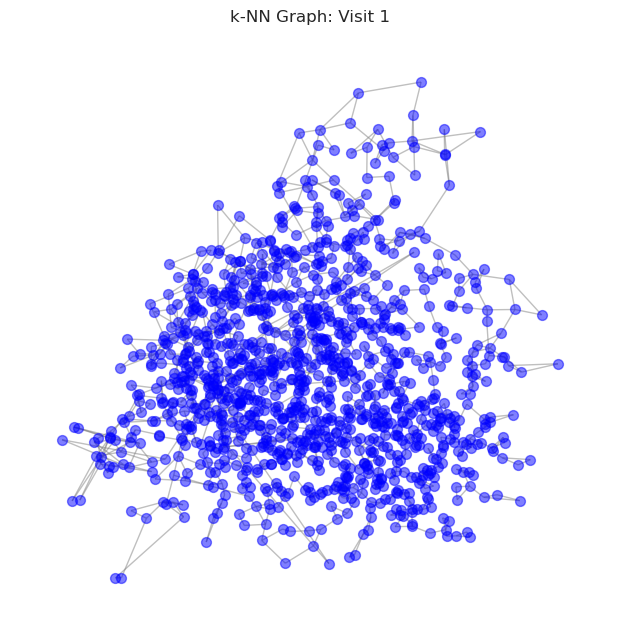

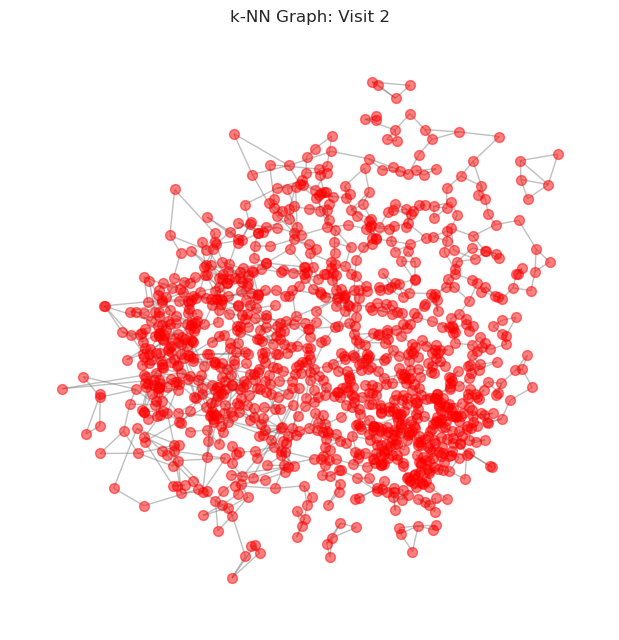

In [212]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors

# Example Data: Replace these with your actual LLE-reduced manifolds
manifold1 = manifolds[0]
manifold2 = manifolds[1]

# Subject IDs corresponding to each manifold
subjects1 = manifolds_x[0].index.tolist()
subjects2 = manifolds_x[1].index.tolist()

# 1. Identify Shared Subjects
shared_subjects = list(set(subjects1) & set(subjects2))
subject_to_index1 = {subj: idx for idx, subj in enumerate(subjects1)}
subject_to_index2 = {subj: idx for idx, subj in enumerate(subjects2)}

# Step 3: Ensure Only Valid Indices are Used
valid_shared_subjects = [s for s in shared_subjects if s in subject_to_index1 and s in subject_to_index2]

# Retrieve the correct indices for shared subjects
indices1 = np.array([subject_to_index1[s] for s in shared_subjects])  # Correct index lookup for manifold1
indices2 = np.array([subject_to_index2[s] for s in shared_subjects])  # Correct index lookup for manifold2

# Extract the shared subjects' coordinates from each manifold
aligned_manifold1 = manifold1[indices1]
aligned_manifold2 = manifold2[indices2]

# 3. Build k-Nearest Neighbor Graphs
k = 3  # Number of nearest neighbors

def compute_knn_graph(manifold, k):
    """Compute k-NN graph for a given manifold."""
    nn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(manifold)
    distances, indices = nn.kneighbors(manifold)
    return indices

knn1 = compute_knn_graph(aligned_manifold1, k)
knn2 = compute_knn_graph(aligned_manifold2, k)

# 4. Compute Neighborhood Preservation Score
def neighborhood_preservation(knn1, knn2):
    """Calculate the percentage of neighbors that are preserved between two k-NN graphs."""
    scores = []
    for i in range(len(knn1)):
        shared_neighbors = len(set(knn1[i]) & set(knn2[i]))  # Intersection of neighbors
        scores.append(shared_neighbors / k)  # Fraction of neighbors preserved
    return np.mean(scores)

preservation_score = neighborhood_preservation(knn1, knn2)
print(f"Neighborhood Preservation Score: {preservation_score:.3f}")

# 5. Visualize the k-NN Graphs
def plot_knn_graph(manifold, knn_indices, title, color='blue'):
    if manifold.shape[1] > 2:
        # print(f"Reducing manifold from {manifold.shape[1]}D to 2D for visualization...")
        pca = PCA(n_components=2)  # Reduce dimensionality
        manifold_2D = pca.fit_transform(manifold)  # Transform to 2D
    else:
        manifold_2D = manifold

    """Plot k-NN graph using NetworkX."""
    G = nx.Graph()
    for i in range(len(manifold_2D)):
        G.add_node(i, pos=tuple(manifold_2D[i]))
        for neighbor in knn_indices[i]:
            if i != neighbor:
                G.add_edge(i, neighbor)

    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, node_color=color, with_labels=False, node_size=50, edge_color='gray', alpha=0.5)
    plt.title(title)
    plt.show()

# Plot k-NN Graphs for Visit 1 and Visit 2
plot_knn_graph(aligned_manifold1, knn1, "k-NN Graph: Visit 1", color='blue')
plot_knn_graph(aligned_manifold2, knn2, "k-NN Graph: Visit 2", color='red')


In [214]:
import networkx as nx
import numpy as np
from scipy.spatial.distance import jaccard
from networkx.algorithms.similarity import graph_edit_distance

def compute_jaccard_similarity(knn1, knn2):
    """Computes Jaccard similarity of neighbor sets between two k-NN graphs."""
    jaccard_scores = []

    for i in range(len(knn1)):  # Iterate through each node
        set1 = set(knn1[i])
        set2 = set(knn2[i])

        intersection_size = len(set1 & set2)
        union_size = len(set1 | set2)

        if union_size == 0:  # Avoid division by zero
            jaccard_scores.append(1.0)  # Perfect match if both are empty
        else:
            jaccard_scores.append(intersection_size / union_size)

    return np.mean(jaccard_scores)

def compute_graph_edit_distance(G1, G2):
    """Computes the graph edit distance (GED) between two k-NN graphs."""
    return nx.graph_edit_distance(G1, G2)  # Small tolerance to speed up

def compute_spectral_distance(G1, G2):
    """Computes the spectral distance between two graphs using Laplacian eigenvalues."""
    L1 = nx.laplacian_matrix(G1).toarray()
    L2 = nx.laplacian_matrix(G2).toarray()

    eigenvalues1 = np.sort(np.linalg.eigvalsh(L1))
    eigenvalues2 = np.sort(np.linalg.eigvalsh(L2))

    return np.linalg.norm(eigenvalues1 - eigenvalues2)  # L2 norm of eigenvalues

def compute_degree_distribution_similarity(G1, G2):
    """Computes degree distribution similarity between two graphs using histogram correlation."""
    degrees1 = [deg for _, deg in G1.degree()]
    degrees2 = [deg for _, deg in G2.degree()]

    hist1, _ = np.histogram(degrees1, bins=20, density=True)
    hist2, _ = np.histogram(degrees2, bins=20, density=True)

    return 1 - np.linalg.norm(hist1 - hist2)  # 1 - L2 norm to measure closeness

# Convert k-NN indices into NetworkX graphs
def knn_to_graph(knn_indices):
    """Converts k-NN neighbor lists to a NetworkX graph."""
    G = nx.Graph()
    for i in range(len(knn_indices)):
        for neighbor in knn_indices[i]:
            if i != neighbor:
                G.add_edge(i, neighbor)
    return G

# Convert k-NN indices to graphs
G1 = knn_to_graph(knn1)
G2 = knn_to_graph(knn2)

# Compute similarity metrics
jaccard_sim = compute_jaccard_similarity(knn1, knn2)
edit_distance = compute_graph_edit_distance(G1, G2)
spectral_distance = compute_spectral_distance(G1, G2)
degree_similarity = compute_degree_distribution_similarity(G1, G2)

# Print results
print(f"Jaccard Similarity of Neighbor Sets: {jaccard_sim:.3f}")
print(f"Graph Edit Distance: {edit_distance:.3f}")
print(f"Laplacian Spectral Distance: {spectral_distance:.3f}")
print(f"Degree Distribution Similarity: {degree_similarity:.3f}")


KeyboardInterrupt: 

In [228]:
SPIROMICS_dataset

X10620_21  X11109_56  X11178_21  X11214_40  X11278_4  X11388_75  \
SUBJID                                                                      
CU100010   0.591663   0.625245   0.443666   0.626426 -0.167169   0.119947   
CU100010   0.217633  -0.113803  -0.195956  -0.473699  0.602742  -0.038038   
CU100010   0.427121  -0.222411  -0.030833  -0.026275  0.400193   0.034641   
CU100023   0.158898  -0.820527  -0.749503  -0.107287 -0.784356  -0.888482   
CU100023   0.806356  -0.928072  -0.932237   0.865684  0.461013  -0.186716   
...             ...        ...        ...        ...       ...        ...   
WF125441   0.372964   0.111962   0.333165  -1.291214 -0.286443   0.413706   
WF125457   1.859563   4.703227   3.905654   0.189848 -0.183309   1.458431   
WF125485   2.967250   0.881214   0.982928   3.803523 -0.112043   2.259366   
WF125503  -1.141280   0.556718   0.299768   1.455290 -0.400526  -0.018034   
WF125503  -1.034716   0.718919   0.861534  -0.054753 -0.115418   0.314567   

          X12549_33  X13397_88  X13565_2  X13660_76  ...  X7893_19  X8245_27  \
SUBJID                                               ...                       
CU100010  -0.162917  -0.560603 -0.339221  -0.376205  ... -0.228897  0.601480   
CU100010  -0.289146  -0.544559 -0.996939  -0.408712  ... -0.206473  0.630914   
CU100010  -0.296257  -0.318407 -0.960166  -0.639526  ...  0.447156  1.511390   
CU100023  -0.411873   0.564561 -0.547886  -0.571452  ... -0.875162  0.427224   
CU100023  -0.483527  -0.520912 -0.650236  -0.472261  ... -0.874940  0.923694   
...             ...        ...       ...        ...  ...       ...       ...   
WF125441   0.948820   0.049508  0.424181   0.673520  ...  0.072245  1.374504   
WF125457  -0.173074  -0.535285  1.092560   1.413232  ...  1.534514  2.873349   
WF125485  -0.226945  -0.087780  3.182787   0.635111  ... -0.491669  1.381391   
WF125503  -0.889780   0.305992  0.732300   0.543579  ...  0.327488 -0.572169   
WF125503  -0.704085   0.461407  2.389335   0.561793  ...  0.298181 -0.275361   

          X8464_31  X8841_65   X8885_6   X9756_6  X9793_145  VISIT  \
SUBJID                                                               
CU100010  0.270160  0.290457  0.118103 -0.180046   0.586793      5   
CU100010  0.163772  0.031381  0.082376 -0.654425   0.588809      2   
CU100010  0.252321  0.243701  0.163521 -0.719232   0.836751      4   
CU100023 -0.228766 -0.855419 -0.611941 -0.520131  -0.213488      5   
CU100023 -0.321564  0.056616 -0.392063 -0.737649   0.178882      2   
...            ...       ...       ...       ...        ...    ...   
WF125441  0.321640  2.483942 -0.732503 -0.558673   0.470208      1   
WF125457  0.726864  0.450223  0.801430  0.549523   0.345325      1   
WF125485  0.371490  0.045845  0.260127  0.958410  -0.458235      1   
WF125503  2.117883  1.361454 -0.042476 -0.318862  -0.520176      1   
WF125503  1.524285  1.152835 -0.517563  0.469993  -0.359741      5   

          GOLD_STAGE_COPD_SEVERITY   age  
SUBJID                                    
CU100010                         0  61.0  
CU100010                         0  62.0  
CU100010                         0  67.0  
CU100023                         0  64.0  
CU100023                         0  66.0  
...                            ...   ...  
WF125441                         2  57.0  
WF125457                         4  65.0  
WF125485                         3  67.0  
WF125503                         2  61.0  
WF125503                         2  65.0  

[5080 rows x 103 columns]


--- Generating Manifold for Visit 0 ---
(1837, 100)
GOLD_STAGE_COPD_SEVERITY
 1    0.410996
 0    0.309200
 2    0.210125
-1    0.069679
Name: proportion, dtype: float64
Reconstruction Error: 0.0081
Neighborhood Preservation Score: 0.0471
Pairwise Distance Preservation Score: 0.5165

--- Generating Manifold for Visit 1 ---
(4445, 100)
GOLD_STAGE_COPD_SEVERITY
 1    0.425872
 0    0.301687
 2    0.190551
-1    0.081890
Name: proportion, dtype: float64
Reconstruction Error: 0.0029
Neighborhood Preservation Score: 0.0339
Pairwise Distance Preservation Score: 0.6427


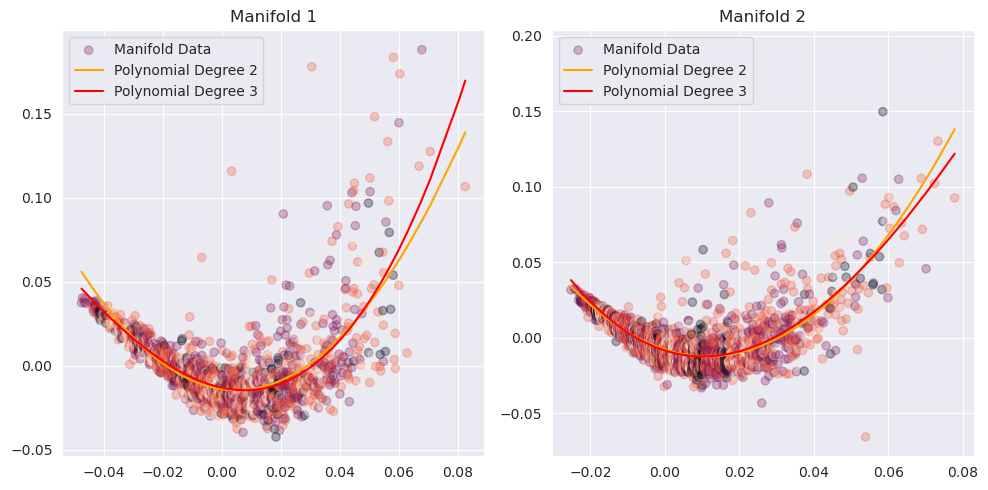

In [309]:
####################################################
#        MANIFOLD STABILITY BETWEEN VISITS         #
####################################################
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd


# Function to Generate and Evaluate Manifold
def generate_manifold(dataset, visit_num, n_neighbors=300, n_components=3, reg=0.01):

    print(f"\n--- Generating Manifold for Visit {visit_num} ---")
    # Feature selection based on correlation
    X = dataset.loc[:, dataset.columns.str.startswith('X')]
    Y = dataset['GOLD_STAGE_COPD_SEVERITY']
    Y_combined_classes = Y.replace(2, 1)
    Y_combined_classes = Y_combined_classes.replace([3, 4], 2)



    kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X, Y):
        x_train = X.iloc[train_index]
        print(x_train.shape)
        y_train = Y.iloc[train_index]
        Y_train_combined_classes = y_train.replace(2, 1)

        Y_train_combined_classes = Y_train_combined_classes.replace([3, 4], 2)
        print(Y_train_combined_classes.value_counts(normalize=True))
        # Apply LLE
        break
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, reg=reg, max_iter=300, random_state=42)

    embedding = lle.fit_transform(x_train)


    # Evaluate the manifold
    reconstruction_error = lle.reconstruction_error_
    neighborhood_preservation_score = calculate_neighborhood_preservation(x_train, embedding)
    pairwise_distances_preservation_score = calculate_distance_preservation(x_train, embedding)

    print("Reconstruction Error: %.4f" % reconstruction_error)
    print("Neighborhood Preservation Score: %.4f" % neighborhood_preservation_score)
    print("Pairwise Distance Preservation Score: %.4f" % pairwise_distances_preservation_score)

    # # 3D Scatter Plot
    # fig = plt.figure(figsize=(12, 10))
    # ax = fig.add_subplot(111, projection='3d')
    # custom_cmap = ListedColormap(['#A02B93', '#196B24', '#E97132', '#6E2D0C'])  # Custom colors
    # sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=Y_train_combined_classes, s=5, alpha=0.7, cmap=custom_cmap)
    #
    # # Add legend
    # legend1 = ax.legend(*sc.legend_elements(), loc="upper center", title="GOLD", ncol=4)
    # ax.add_artist(legend1)
    #
    # # Hide grid and axes for cleaner plot
    # ax.grid(False)
    # ax.set_axis_off()
    # fig.patch.set_alpha(0.0)
    #
    # plt.title(f"3D LLE Manifold for Visit {visit_num}")
    # plt.show()
    return x_train, Y_train_combined_classes, embedding


SPIROMICS_datasets = [SPIROMICS_dataset_P1, SPIROMICS_dataset]
manifolds = []
manifolds_x = []
manifolds_y = []
# Generate Manifolds for Visit 1, 2, and 3
for idx, SPIROMICS_dataset_ in enumerate(SPIROMICS_datasets):
    if idx == 0:
        x, y, manifold = generate_manifold(SPIROMICS_dataset_, visit_num=idx, n_components=3, n_neighbors=45, reg=0.0036638517289616286)
    else:
        x, y, manifold = generate_manifold(SPIROMICS_dataset_, visit_num=idx, n_components=3, n_neighbors=50, reg=0.0036638517289616286)
    manifolds.append(manifold)
    manifolds_x.append(x)
    manifolds_y.append(y)



# Align all manifolds to the first one (as reference)
reference_manifold = manifolds[0]
aligned_manifolds = []
similarity_scores = []


for i, manifold in enumerate(manifolds):
    # print(reference_manifold.shape)
    # print(manifold.shape)
    min_length = min(reference_manifold.shape[0], manifold.shape[0])
    reference_manifold = reference_manifold[:min_length]
    manifold = manifold[:min_length]


    aligned, similarity = align_manifolds(reference_manifold, manifold)
    aligned_manifolds.append(aligned)
    similarity_scores.append(similarity)
    # print(f"Manifold {i+1} aligned to reference with similarity score: {similarity:.4f}")

# Qualitative comparison - visualize manifolds
fig, axes = plt.subplots(1, len(manifolds), figsize=(10, 5))
for i, manifold in enumerate(manifolds):
    x_vals = manifold[:, 0]
    y_vals = manifold[:, 1]
    if i == 1:
        x_vals = -x_vals
        y_vals = -y_vals

    # axes[i].scatter(manifold[:, 0], manifold[:, 1], c=manifolds_y[i], cmap='viridis', s=10)
    # axes[i].set_title(f"Manifold Split {i+1}")


    # Sort x-values and corresponding y-values to ensure smooth polynomial fit
    sorted_indices = np.argsort(x_vals)
    x_sorted = x_vals[sorted_indices]
    y_sorted = y_vals[sorted_indices]

    poly2_model, _, r2_poly2, rmse_poly2, y_poly2 = fit_polynomial(x_sorted, y_sorted, degree=2)
    poly3_model, _, r2_poly3, rmse_poly3, y_poly3 = fit_polynomial(x_sorted, y_sorted, degree=3)
    # spline_model, rmse_spline, y_spline = fit_spline(x_sorted, y_sorted, smoothing_factor=0.001)

    axes[i].scatter(x_sorted, y_sorted, c=manifolds_y[i], alpha=0.3, label="Manifold Data")
    axes[i].plot(x_sorted, y_poly2, color='orange', label="Polynomial Degree 2")
    axes[i].plot(x_sorted, y_poly3, color='red', label="Polynomial Degree 3")
    # axes[i].plot(x_sorted, y_spline, color='green', linestyle='dashed', label="Spline Fit")
    axes[i].set_title(f"Manifold {i+1}")
    axes[i].legend()

plt.tight_layout()
plt.show()

# # Visualize the aligned manifolds
# fig, axes = plt.subplots(1, len(aligned_manifolds), figsize=(10, 10))
# for i, aligned_manifold in enumerate(aligned_manifolds):
#     # Ensure the sizes match by truncating the longer array
#     min_length = min(aligned_manifold.shape[0], len(manifolds_y[i]))
#     aligned_manifold = aligned_manifold[:min_length]
#     manifold_y = manifolds_y[i][:min_length]
#     axes[i].scatter(aligned_manifold[:, 0], aligned_manifold[:, 1], c=manifold_y, cmap='viridis', s=10)
#     axes[i].set_title(f"Aligned Manifold {i+1}")
# plt.tight_layout()
# plt.show()


Longitudinally-Aware LLE Embedding: (5080, 3)


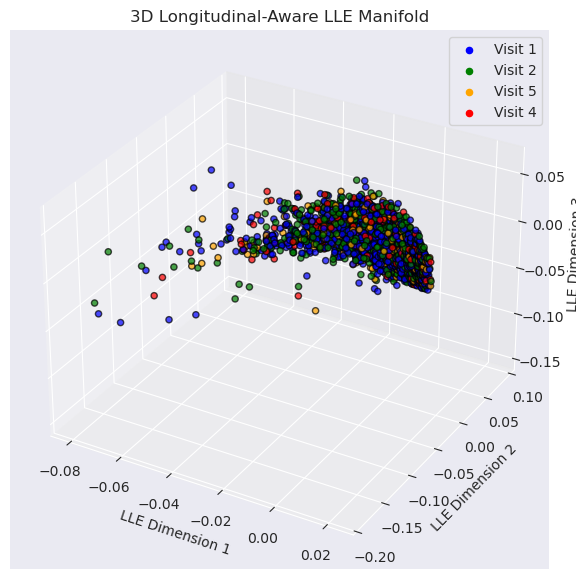

In [229]:
import numpy as np
import pandas as pd
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import NearestNeighbors

# Step 1: Load and Prepare Data
X = SPIROMICS_dataset.loc[:, SPIROMICS_dataset.columns.str.startswith('X')].values # Extract protein features
subject_ids = SPIROMICS_dataset.index.tolist()  # Subject IDs from index
visit_numbers = SPIROMICS_dataset["VISIT"].values  # Visit numbers

# Step 2: Custom Nearest Neighbors Excluding Longitudinal Dependencies
def custom_nearest_neighbors(X, subject_ids, visit_numbers, n_neighbors=5):
    """
    Compute nearest neighbors while excluding subsequent visits of the same subject.

    Parameters:
    - X: np.array (n_samples, n_features), the high-dimensional data.
    - subject_ids: list of subject IDs (index of dataframe).
    - visit_numbers: list/array of visit numbers for each subject.
    - n_neighbors: int, number of valid neighbors to find.

    Returns:
    - valid_neighbors: np.array (n_samples, n_neighbors), indices of allowed neighbors.
    """
    nn = NearestNeighbors(n_neighbors=n_neighbors+5, algorithm='ball_tree')  # Extra to account for filtering
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    valid_neighbors = []
    for i in range(len(X)):
        subject, visit = subject_ids[i], visit_numbers[i]

        # Filter out neighbors that belong to the same subject but different visits
        filtered_neighbors = [idx for idx in indices[i] if subject_ids[idx] != subject]

        # Ensure we have exactly `n_neighbors`
        valid_neighbors.append(filtered_neighbors[:n_neighbors])

    return np.array(valid_neighbors)

# Step 3: Modify LLE to Use Custom Neighbors
class LongitudinalLLE(LocallyLinearEmbedding):
    def __init__(self, n_neighbors=5, n_components=2, reg=0.0036638517289616286, method='standard', **kwargs):
        super().__init__(n_neighbors=n_neighbors, n_components=n_components, reg=reg, method=method, **kwargs)

    def fit_transform(self, X, subject_ids, visit_numbers):
        """
        Apply LLE while ensuring no subject's visits are neighbors.

        Parameters:
        - X: np.array (n_samples, n_features), input high-dimensional data.
        - subject_ids: list of subject IDs corresponding to each sample.
        - visit_numbers: list/array of visit numbers for each subject.

        Returns:
        - X_embedded: np.array (n_samples, n_components), transformed LLE manifold.
        """
        # Compute valid neighbors excluding the same subject's other visits
        valid_neighbors = custom_nearest_neighbors(X, subject_ids, visit_numbers, self.n_neighbors)

        # Override LLE’s internal neighbors and apply the transformation
        self.nbrs_ = valid_neighbors
        return super().fit_transform(X)

# Step 4: Run Longitudinal-Aware LLE
lle = LongitudinalLLE(n_neighbors=45, n_components=3, method='standard')
lle_embedding = lle.fit_transform(X, subject_ids, visit_numbers)

print("Longitudinally-Aware LLE Embedding:", lle_embedding.shape)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Extract Visit Numbers for Coloring
visit_numbers = SPIROMICS_dataset["VISIT"].values
subject_ids = SPIROMICS_dataset.index.tolist()  # Extract subject IDs

# Define a color palette for visits
visit_palette = {1: "blue", 2: "green", 5: "orange", 4: "red"}
colors = [visit_palette[v] for v in visit_numbers]

# Create 3D Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter Plot of the 3D Manifold
ax.scatter(lle_embedding[:, 0], lle_embedding[:, 1], lle_embedding[:, 2],
           c=colors, alpha=0.7, edgecolor='k', s=20)

ax.set_xlabel("LLE Dimension 1")
ax.set_ylabel("LLE Dimension 2")
ax.set_zlabel("LLE Dimension 3")
ax.set_title("3D Longitudinal-Aware LLE Manifold")

# Add Legend for Visits
for visit, color in visit_palette.items():
    ax.scatter([], [], [], c=color, label=f'Visit {visit}')
ax.legend()

plt.show()


Manifold 1 aligned to reference with similarity score: 1.0000
Manifold 2 aligned to reference with similarity score: 0.0008


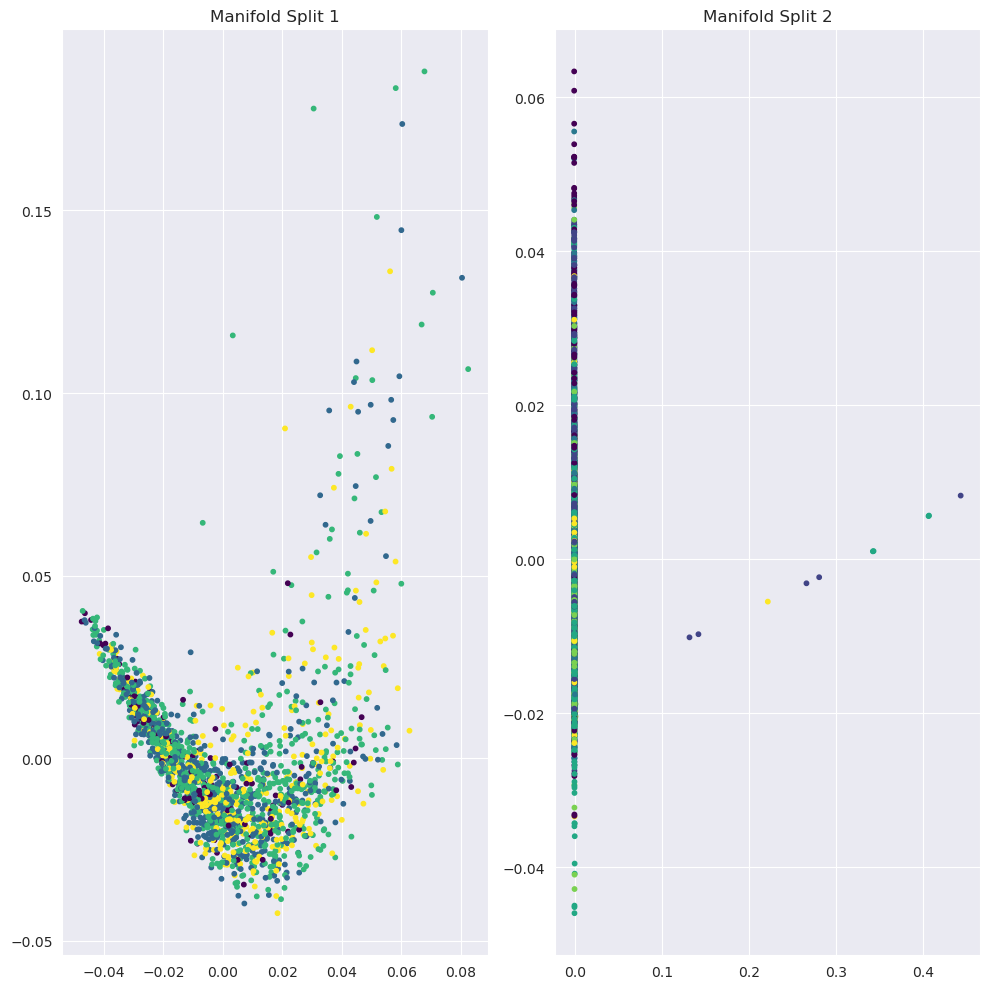

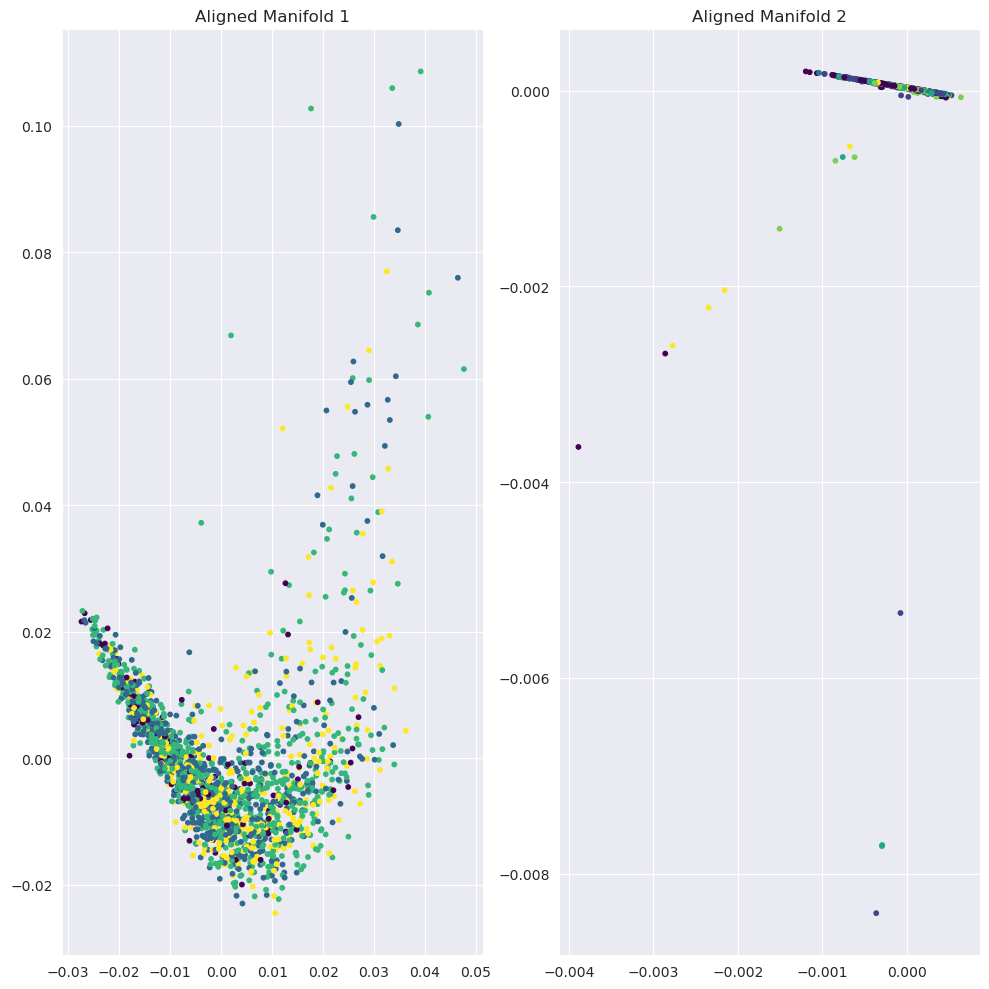

In [223]:
# Align all manifolds to the first one (as reference)
reference_manifold = manifolds[0]
aligned_manifolds = []
similarity_scores = []

manifolds_new = []
manifolds_new.append(manifolds[0])
manifolds_new.append(lle_embedding)
manifolds_new_y = []
manifolds_new_y.append(manifolds_y[0])
manifolds_new_y.append(SPIROMICS_dataset['GOLD_STAGE_COPD_SEVERITY'].values)

for i, manifold in enumerate(manifolds_new):
    # print(reference_manifold.shape)
    # print(manifold.shape)
    min_length = min(reference_manifold.shape[0], manifold.shape[0])
    reference_manifold = reference_manifold[:min_length]
    manifold = manifold[:min_length]


    aligned, similarity = align_manifolds(reference_manifold, manifold)
    aligned_manifolds.append(aligned)
    similarity_scores.append(similarity)
    print(f"Manifold {i+1} aligned to reference with similarity score: {similarity:.4f}")

# Qualitative comparison - visualize manifolds
fig, axes = plt.subplots(1, len(manifolds_new), figsize=(10, 10))
for i, manifold in enumerate(manifolds_new):
    axes[i].scatter(manifold[:, 0], manifold[:, 1], c=manifolds_new_y[i], cmap='viridis', s=10)
    axes[i].set_title(f"Manifold Split {i+1}")
plt.tight_layout()
plt.show()

# Visualize the aligned manifolds
fig, axes = plt.subplots(1, len(aligned_manifolds), figsize=(10, 10))
for i, aligned_manifold in enumerate(aligned_manifolds):
    # Ensure the sizes match by truncating the longer array
    min_length = min(aligned_manifold.shape[0], len(manifolds_y[i]))
    aligned_manifold = aligned_manifold[:min_length]
    manifold_y = manifolds_new_y[i][:min_length]
    axes[i].scatter(aligned_manifold[:, 0], aligned_manifold[:, 1], c=manifold_y, cmap='viridis', s=10)
    axes[i].set_title(f"Aligned Manifold {i+1}")
plt.tight_layout()
plt.show()


--- Generating Manifold for Visit 0 ---
          X10620_21  X11109_56  X11178_21  X11214_40  X11278_4  X11388_75  \
SUBJID                                                                      
CU100047  -0.175359   0.916606   1.100159  -0.216662  0.195211   0.630947   
CU100079  -0.681373  -0.380333  -0.314356  -0.400411 -0.423152  -1.040169   
CU100103  -0.942848  -0.527594  -0.523970  -0.379127  0.232251  -0.377646   
CU100139  -0.830272  -0.807054  -0.796854  -0.385546 -0.901977  -1.023318   
CU100178  -1.066274  -0.276491  -0.321933  -0.851124 -0.688403  -1.470730   
...             ...        ...        ...        ...       ...        ...   
WF125429   0.037456  -0.101192  -0.323553  -1.512402 -0.826849   0.412262   
WF125441   0.372964   0.111962   0.333165  -1.291214 -0.286443   0.413706   
WF125457   1.859563   4.703227   3.905654   0.189848 -0.183309   1.458431   
WF125485   2.967250   0.881214   0.982928   3.803523 -0.112043   2.259366   
WF125503  -1.141280   0.556718   0.

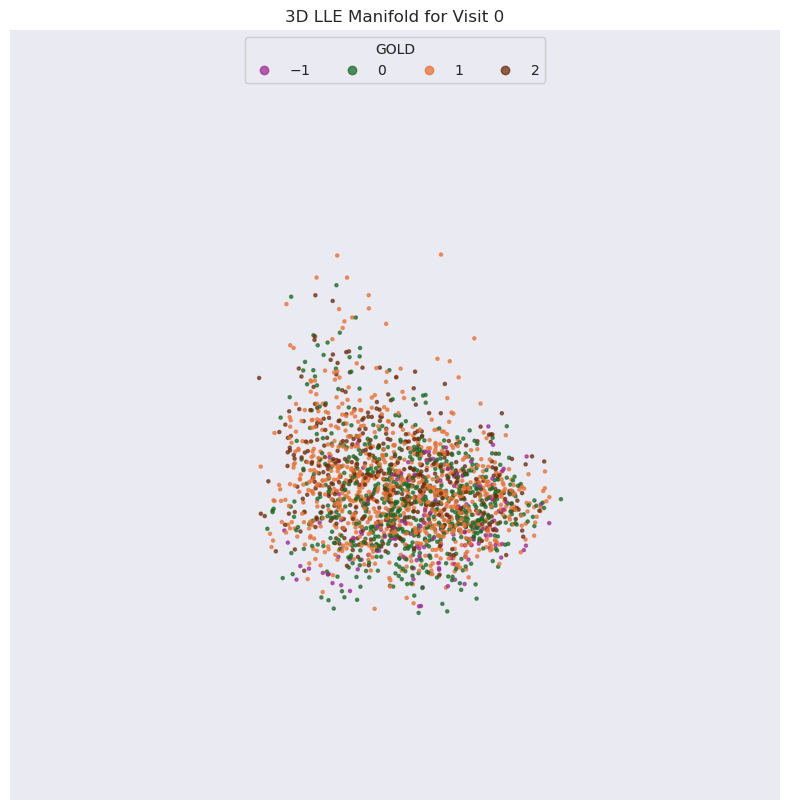


--- Generating Manifold for Visit 1 ---
          X10620_21  X11109_56  X11178_21  X11214_40  X11278_4  X11388_75  \
SUBJID                                                                      
CU100010   0.217633  -0.113803  -0.195956  -0.473699  0.602742  -0.038038   
CU100023   0.806356  -0.928072  -0.932237   0.865684  0.461013  -0.186716   
CU100047  -0.087150   0.846624   1.075544   1.477894  1.340740   1.637826   
CU100068  -0.930978  -0.049773  -0.252868  -0.467976 -1.285604  -0.645851   
CU100079   0.206286   0.019866   0.120258   0.995914  0.645288   0.511053   
...             ...        ...        ...        ...       ...        ...   
WF124980  -0.021294   0.239300   0.519377   1.204478  0.644995   1.299064   
WF124995   0.033819   1.728479   1.784194   0.081214  0.141679   1.161808   
WF125000  -0.608255  -0.342105  -0.187532   1.540906 -0.279791   1.019521   
WF125183   0.684438   0.133530   0.026529   0.846182 -0.535279   1.308223   
WF125209   0.286877  -0.611150  -0.

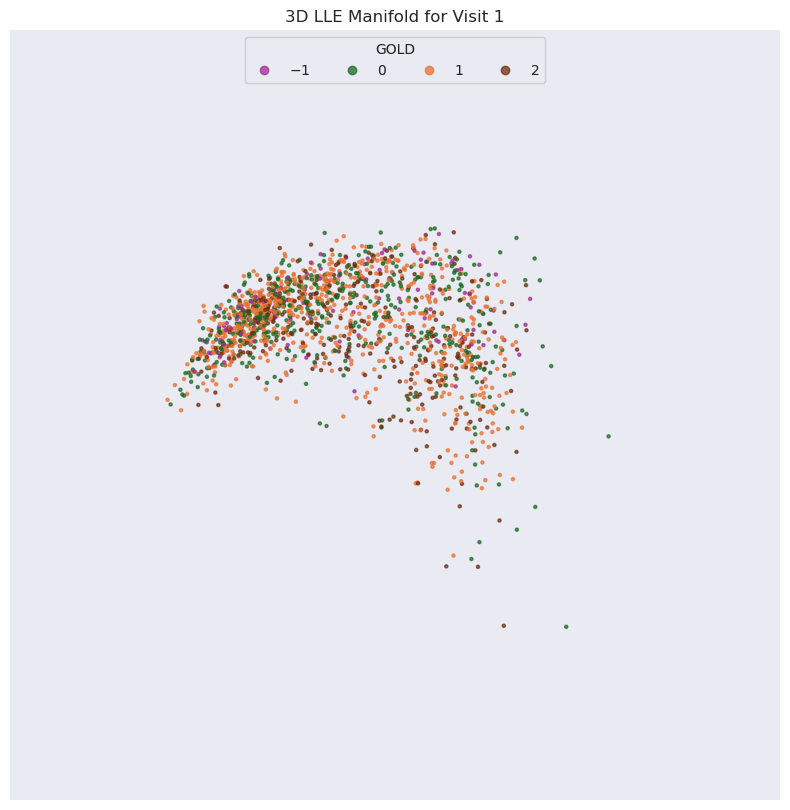

In [102]:
####################################################
#        MANIFOLD STABILITY BETWEEN VISITS         #
####################################################
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd

# Function to Generate and Evaluate Manifold
def generate_manifold(dataset, visit_num, k=30, n_neighbors=300, n_components=3):

    print(f"\n--- Generating Manifold for Visit {visit_num} ---")
    # Feature selection based on correlation
    X = dataset.loc[:, dataset.columns.str.startswith('X')]
    Y = dataset['GOLD_STAGE_COPD_SEVERITY']
    Y_combined_classes = Y.replace(2, 1)
    Y_combined_classes = Y_combined_classes.replace([3, 4], 2)
    print(X)


    # # Select top k features
    # corr = X_all.corrwith(Y_all).abs().sort_values(ascending=False)
    # trimmed = X[corr[:k].index.tolist()]
    # # print(trimmed.columns)
    #
    # # Standardize the dataset
    # scaler = StandardScaler()
    # trimmed = pd.DataFrame(scaler.fit_transform(trimmed), columns=trimmed.columns)

    # Run LLE
    # lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components,
    #                              reg=0.001, max_iter=1000, random_state=42)
    # lle = LocallyLinearEmbedding(n_neighbors=45, n_components=3,
    #                              reg=0.0036638517289616286, max_iter=300, random_state=42)
    # lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components,
    #                              reg=0.009744881688309249, max_iter=300, random_state=42, method='hessian',
    #                              eigen_solver='dense', hessian_tol=0.00013886458741314928)
    # lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components,
    #                              reg=0.006363760494038891, max_iter=300, random_state=42, method='modified',
    #                              modified_tol=0.00013886458741314928)
    lle = LocallyLinearEmbedding(n_components=3, n_neighbors=45, reg=0.0036638517289616286, max_iter=300, random_state=42)
    embedding = lle.fit_transform(X)

    # Evaluate the manifold
    reconstruction_error = lle.reconstruction_error_
    neighborhood_preservation_score = calculate_neighborhood_preservation(X, embedding)
    pairwise_distances_preservation_score = calculate_distance_preservation(X, embedding)

    print("Reconstruction Error: %.4f" % reconstruction_error)
    print("Neighborhood Preservation Score: %.4f" % neighborhood_preservation_score)
    print("Pairwise Distance Preservation Score: %.4f" % pairwise_distances_preservation_score)

    # 3D Scatter Plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    custom_cmap = ListedColormap(['#A02B93', '#196B24', '#E97132', '#6E2D0C'])  # Custom colors
    sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=Y_combined_classes, s=5, alpha=0.7, cmap=custom_cmap)

    # Add legend
    legend1 = ax.legend(*sc.legend_elements(), loc="upper center", title="GOLD", ncol=4)
    ax.add_artist(legend1)

    # Hide grid and axes for cleaner plot
    ax.grid(False)
    ax.set_axis_off()
    fig.patch.set_alpha(0.0)

    plt.title(f"3D LLE Manifold for Visit {visit_num}")
    plt.show()
    return embedding

X_all = SPIROMICS_dataset.loc[:, SPIROMICS_dataset.columns.str.startswith('X')]
Y_all = SPIROMICS_dataset['GOLD_STAGE_COPD_SEVERITY']

SPIROMICS_datasets = [SPIROMICS_dataset_P1, SPIROMICS_dataset_P2]
manifolds = []
# Generate Manifolds for Visit 1, 2, and 3
for idx, SPIROMICS_dataset_ in enumerate(SPIROMICS_datasets):
    manifolds.append(generate_manifold(SPIROMICS_dataset_, visit_num=idx))



In [33]:
# Functions for Quality Metrics
def pairwise_distance_stress(X1, X2):
    """Compute stress between pairwise distances of two manifolds."""
    D1 = squareform(pdist(X1))
    D2 = squareform(pdist(X2))
    stress = np.sqrt(np.sum((D1 - D2)**2) / np.sum(D1**2))
    return stress

def neighborhood_preservation(X1, X2, k=5):
    """Compute neighborhood preservation between two manifolds."""
    from sklearn.neighbors import NearestNeighbors
    nbrs1 = NearestNeighbors(n_neighbors=k).fit(X1)
    nbrs2 = NearestNeighbors(n_neighbors=k).fit(X2)
    knn1 = nbrs1.kneighbors(X1, return_distance=False)
    knn2 = nbrs2.kneighbors(X2, return_distance=False)
    scores = [len(set(knn1[i]) & set(knn2[i])) / k for i in range(X1.shape[0])]
    return np.mean(scores)

# Stability function
def manifold_stability(data, n_subsamples=10, sample_size=0.8, n_neighbors=15, n_components=3, k=30):
    """
    Measure the stability of a manifold using subsampling and consistency metrics.
    :param data: Input high-dimensional data (n_samples, n_features)
    :param n_subsamples: Number of random subsamples
    :param sample_size: Fraction of data to subsample (0 < sample_size <= 1)
    :param n_neighbors: Number of neighbors for LLE
    :param n_components: Number of components for LLE
    :param k: Number of neighbors for neighborhood preservation
    :return: Dictionary with average and std of metrics
    """
    metrics = {
        "Pairwise Distance Stress": [],
        "Neighborhood Preservation": []
    }
    manifolds = []

    X = data.loc[:, data.columns.str.startswith('X')]
    Y = COPDGene_dataset['finalgold_visit']
    corr = X.corrwith(Y).abs().sort_values(ascending=False)
    trimmed = X[corr[:k].index.tolist()]


    # Standardize the dataset
    scaler = StandardScaler()
    trimmed = pd.DataFrame(scaler.fit_transform(trimmed), columns=trimmed.columns)

    # Generate subsampled manifolds
    for i in range(n_subsamples):
        subsample = resample(trimmed, n_samples=int(sample_size * len(data)), random_state=i)
        lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, random_state=42)
        embedding = lle.fit_transform(subsample)
        manifolds.append(embedding)

    # Compare all pairs of manifolds
    for idx1, idx2 in combinations(range(len(manifolds)), 2):
        X1, X2 = manifolds[idx1], manifolds[idx2]
        stress = pairwise_distance_stress(X1, X2)
        preservation = neighborhood_preservation(X1, X2, k=k)
        metrics["Pairwise Distance Stress"].append(stress)
        metrics["Neighborhood Preservation"].append(preservation)

    # Compute averages and standard deviations
    results = {key: (np.mean(val), np.std(val)) for key, val in metrics.items()}
    return results


np.random.seed(42)
# Measure stability
stability_results = manifold_stability(COPDGene_dataset_P3, n_subsamples=10, sample_size=0.8, n_neighbors=30, n_components=3, k=50)

# Print results
print("Manifold Stability Results:")
for metric, (mean, std) in stability_results.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Manifold Stability Results:
Pairwise Distance Stress: Mean = 0.5951, Std = 0.0231
Neighborhood Preservation: Mean = 0.6175, Std = 0.0160


In [58]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Compute pairwise distance matrices for all manifolds
distance_matrices = [pairwise_distances(manifold) for manifold in manifolds]

# Compute similarity between distance matrices (e.g., Pearson correlation)
def compare_distance_matrices(dm1, dm2):
    dm1_flat = dm1.flatten()
    dm2_flat = dm2.flatten()
    correlation = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
    return correlation

# Compare all manifolds to the first one
reference_matrix = distance_matrices[0]
similarities = [compare_distance_matrices(reference_matrix, dm) for dm in distance_matrices]

# Print similarity scores
for i, similarity in enumerate(similarities):
    print(f"Similarity of Manifold {i+1} to Reference: {similarity:.4f}")


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 521284 and the array at index 1 has size 522729

In [59]:
def explained_variance(manifold):
    _, s, _ = np.linalg.svd(manifold, full_matrices=False)
    variance = np.cumsum(s**2) / np.sum(s**2)
    return variance

# Compute explained variance for each manifold
explained_variances = [explained_variance(manifold) for manifold in manifolds]

# Print the variance explained by the first few dimensions
for i, variance in enumerate(explained_variances):
    print(f"Explained Variance for Manifold {i+1}: {variance[:3]}")  # First 3 components


Explained Variance for Manifold 1: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 2: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 3: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 4: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 5: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 6: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 7: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 8: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 9: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 10: [0.33333333 0.66666667 1.        ]


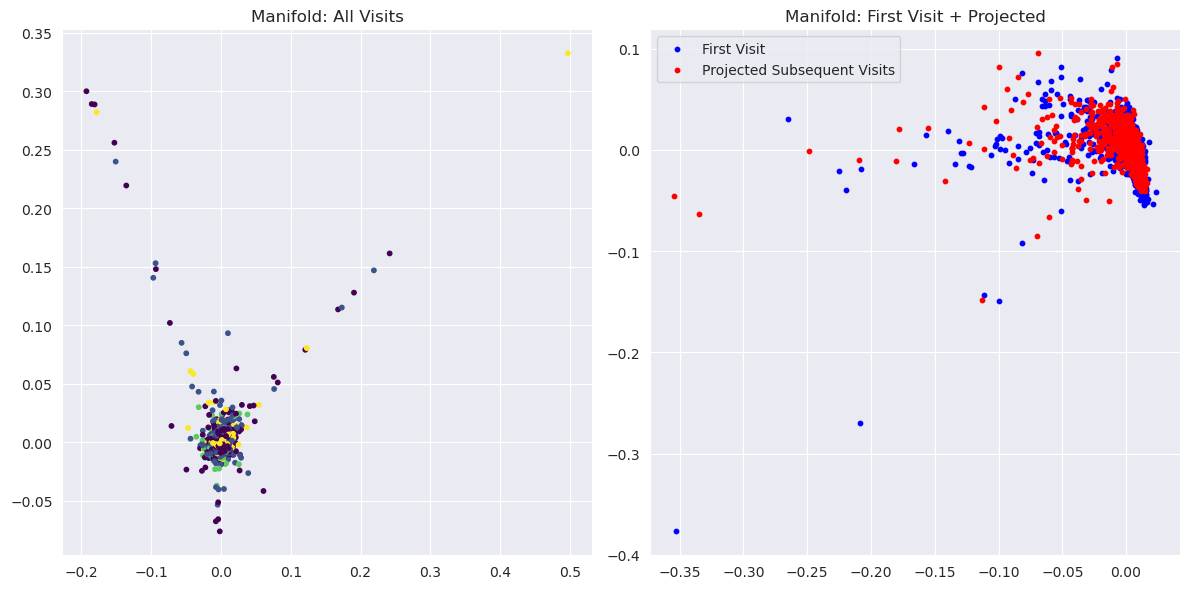

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4410000 and the array at index 1 has size 2735716

In [122]:
#############################################################
# Understanding the Impact of Dependence on the Manifold?!? #
#############################################################
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to generate a manifold
def generate_manifold(data, n_components=2, n_neighbors=50):
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    manifold = lle.fit_transform(data)
    return manifold, lle

# Generate a Manifold using All Visits
manifold_all, lle_all = generate_manifold(SPIROMICS_dataset.loc[:, SPIROMICS_dataset.columns.str.startswith('X')])

# Generate a Manifold using only the First Visit
manifold_first, lle_first = generate_manifold(SPIROMICS_dataset_P1.loc[:, SPIROMICS_dataset_P1.columns.str.startswith('X')])

# Project subsequent visits onto the first visit manifold
# SPIROMICS_dataset_subsequent_visits = SPIROMICS_dataset[SPIROMICS_dataset['VISIT'].isin([2, 4, 5])]
SPIROMICS_dataset_subsequent_visits = SPIROMICS_dataset[SPIROMICS_dataset['VISIT'].isin([2])]
projected_subsequent_visits = lle_first.transform(SPIROMICS_dataset_subsequent_visits.loc[:, SPIROMICS_dataset_subsequent_visits.columns.str.startswith('X')])

# Visualize the two manifolds side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot manifold generated from all visits
axes[0].scatter(manifold_all[:, 0], manifold_all[:, 1], c=SPIROMICS_dataset["VISIT"], cmap="viridis", s=10)
axes[0].set_title("Manifold: All Visits")

# Plot manifold from first visit with projected subsequent visits
axes[1].scatter(manifold_first[:, 0], manifold_first[:, 1], c="blue", label="First Visit", s=10)
axes[1].scatter(projected_subsequent_visits[:, 0], projected_subsequent_visits[:, 1], c="red", label="Projected Subsequent Visits", s=10)
axes[1].set_title("Manifold: First Visit + Projected")
axes[1].legend()

plt.tight_layout()
plt.show()

# Quantitative comparison: Pairwise distance preservation
def compare_distance_matrices(dm1, dm2):
    dm1_flat = dm1.flatten()
    dm2_flat = dm2.flatten()
    correlation = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
    return correlation

# Compute pairwise distance matrices
dm_all = pairwise_distances(manifold_all)
dm_first = pairwise_distances(manifold_first)
dm_projected = pairwise_distances(projected_subsequent_visits)

# Compare distances
all_vs_first = compare_distance_matrices(dm_all[:len(dm_first), :len(dm_first)], dm_first)
first_vs_projected = compare_distance_matrices(dm_first, dm_projected)

print(f"Distance Correlation (All Visits vs First Visit): {all_vs_first:.4f}")
print(f"Distance Correlation (First Visit vs Projected Subsequent Visits): {first_vs_projected:.4f}")


['JH113081', 'UI250372', 'JH112601', 'LA191759', 'MU164580', 'JH110267', 'UT170653', 'CU104149', 'WF122072', 'CU100195', 'MU160965', 'SF180735', 'MU160181', 'SF180283', 'SF181135', 'CU100178', 'MU161130', 'MU162879', 'NJ220477', 'WF120603', 'NJ220481', 'IA210123', 'CU100139', 'MU161107', 'SF180838', 'MU161191', 'CU102006', 'LA190736', 'MU162245', 'LA191567', 'WF121299', 'UT172656', 'MU160789', 'LA190213', 'UT171515', 'LA190769', 'SF180702', 'SF180926', 'LA191364', 'MU160809', 'MU161174', 'LA190722', 'CU103820', 'UT170233', 'MU162059', 'JH114236', 'MU160459', 'LA190608', 'LA190453', 'CU100419', 'UT173238', 'WF120433', 'MU161799', 'WF122515', 'SF182175', 'WF121810', 'WF121625', 'MU161365', 'JH110280', 'MU164331', 'UT171105', 'JH111569', 'MU160976', 'UT172073', 'UT172140', 'SF182863', 'WF123043', 'MU161189', 'UT170416', 'WF121348', 'MU163056', 'MU161027', 'WF123064', 'SF180421', 'CU100582', 'LA191462', 'SF180041', 'JH110070', 'CU102246', 'SF180201', 'SF180918', 'JH110130', 'UT173823', 'LA

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

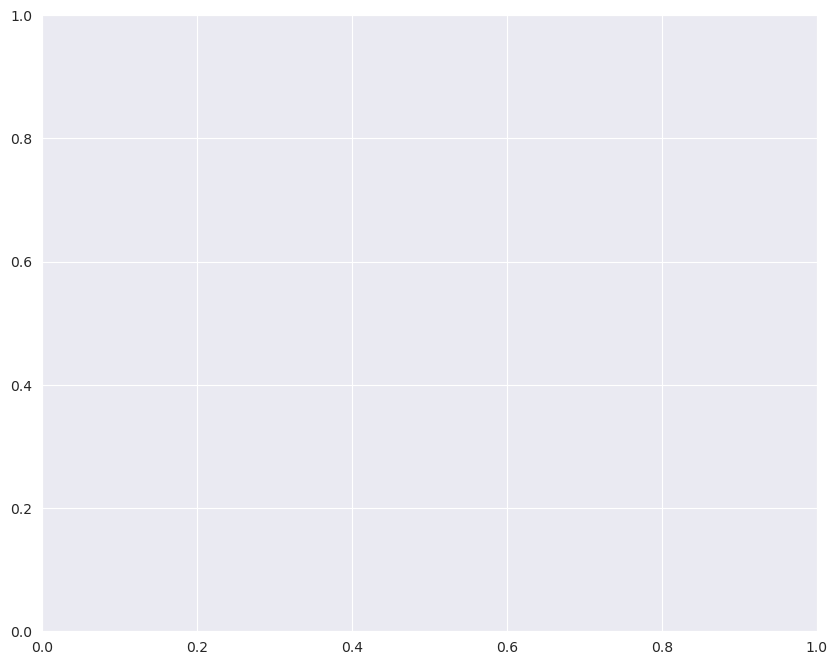

In [72]:
import random

# Randomly select 100 subjects
random_subjects = random.sample(list(SPIROMICS_dataset.index.unique()), 100)
print(random_subjects)

# Filter datasets for selected subjects
selected_first_visit_data = SPIROMICS_dataset_P1[SPIROMICS_dataset_P1.index.isin(random_subjects)]
selected_subsequent_visit_data = SPIROMICS_dataset_subsequent_visits[SPIROMICS_dataset_subsequent_visits.index.isin(random_subjects)]

# Map colors to the selected subjects
selected_subject_ids = selected_first_visit_data.index.unique()
subject_color_map = {subject: i for i, subject in enumerate(selected_subject_ids)}

# Assign colors to the selected first visit and subsequent visits
first_visit_colors = selected_first_visit_data.index.map(subject_color_map)
subsequent_visit_colors = selected_subsequent_visit_data.index.map(subject_color_map)

# Visualize the manifold with points colored by subject ID (for 100 random subjects)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first visit manifold
scatter1 = ax.scatter(
    manifold_first[selected_first_visit_data.index, 0], manifold_first[selected_first_visit_data.index, 1],
    c=first_visit_colors,
    cmap="tab20",  # Use a larger qualitative color map for more subjects
    s=50,
    label="First Visit"
)

# Plot the projected subsequent visits
scatter2 = ax.scatter(
    projected_subsequent_visits[selected_subsequent_visit_data.index, 0], projected_subsequent_visits[selected_subsequent_visit_data.index, 1],
    c=subsequent_visit_colors,
    cmap="tab20",
    s=50,
    marker="x",
    label="Subsequent Visits"
)

# Add legend
legend1 = ax.legend(
    *scatter1.legend_elements(num=len(selected_subject_ids)),
    loc="upper right",
    title="Subjects"
)
ax.add_artist(legend1)

ax.set_title("Manifold: First Visit + Projected Subsequent Visits (Random 100 Subjects)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
plt.show()


In [120]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np


# Prepare data for LLE
features = SPIROMICS_dataset.loc[:, SPIROMICS_dataset.columns.str.startswith('X')]
metadata = SPIROMICS_dataset[["VISIT", "GOLD_STAGE_COPD_SEVERITY"]]

# Define LLE
n_neighbors = 10  # Number of neighbors for LLE
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=3)

# Fit LLE to the data
lle.fit(features)

# Compute the k-nearest neighbors graph
neighbors_model = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
neighbors_model.fit(features)
distances, indices = neighbors_model.kneighbors(features)

# Analyze the neighbors for each point
neighbor_analysis = []

for i, subject_idx in enumerate(features.index):
    subject_metadata = metadata.iloc[i]
    sid = subject_idx
    visitnum = subject_metadata["VISIT"]
    phenotype = subject_metadata["GOLD_STAGE_COPD_SEVERITY"]

    # Neighbors
    neighbors = indices[i]

    # Count within-subject neighbors
    within_subject_count = sum(metadata.iloc[neighbor]["VISIT"] != visitnum for neighbor in neighbors if metadata.index[neighbor] == sid)

    # Count phenotype-based neighbors
    phenotype_count = sum(metadata.iloc[neighbor]["GOLD_STAGE_COPD_SEVERITY"] == phenotype and metadata.index[neighbor] != sid for neighbor in neighbors)

    # Save the analysis
    neighbor_analysis.append({
        "SID": sid,
        "Visitnum": visitnum,
        "Within_Subject_Neighbors": within_subject_count,
        "Phenotype_Based_Neighbors": phenotype_count,
        "Total_Neighbors": len(neighbors)
    })

# Convert to a DataFrame
neighbor_analysis_df = pd.DataFrame(neighbor_analysis)

# Compute proportions
neighbor_analysis_df["Within_Subject_Proportion"] = neighbor_analysis_df["Within_Subject_Neighbors"] / neighbor_analysis_df["Total_Neighbors"]
neighbor_analysis_df["Phenotype_Based_Proportion"] = neighbor_analysis_df["Phenotype_Based_Neighbors"] / neighbor_analysis_df["Total_Neighbors"]

# Display the results
print(neighbor_analysis_df)

# Aggregate results
mean_within_subject_proportion = neighbor_analysis_df["Within_Subject_Proportion"].mean()
mean_phenotype_based_proportion = neighbor_analysis_df["Phenotype_Based_Proportion"].mean()

print(f"Mean Within-Subject Neighbor Proportion: {mean_within_subject_proportion:.4f}")
print(f"Mean Phenotype-Based Neighbor Proportion: {mean_phenotype_based_proportion:.4f}")


           SID  Visitnum  Within_Subject_Neighbors  Phenotype_Based_Neighbors  \
0     CU100010         5                         2                          3   
1     CU100010         2                         2                          1   
2     CU100010         4                         2                          2   
3     CU100023         5                         1                          5   
4     CU100023         2                         0                          4   
...        ...       ...                       ...                        ...   
5075  WF125441         1                         0                          3   
5076  WF125457         1                         0                          1   
5077  WF125485         1                         0                          1   
5078  WF125503         1                         1                          2   
5079  WF125503         5                         1                          4   

      Total_Neighbors  With

In [121]:
neighbor_analysis_df

SID  Visitnum  Within_Subject_Neighbors  Phenotype_Based_Neighbors  \
0     CU100010         5                         2                          3   
1     CU100010         2                         2                          1   
2     CU100010         4                         2                          2   
3     CU100023         5                         1                          5   
4     CU100023         2                         0                          4   
...        ...       ...                       ...                        ...   
5075  WF125441         1                         0                          3   
5076  WF125457         1                         0                          1   
5077  WF125485         1                         0                          1   
5078  WF125503         1                         1                          2   
5079  WF125503         5                         1                          4   

      Total_Neighbors  Within_Subject_Proportion  Phenotype_Based_Proportion  
0                  10                        0.2                         0.3  
1                  10                        0.2                         0.1  
2                  10                        0.2                         0.2  
3                  10                        0.1                         0.5  
4                  10                        0.0                         0.4  
...               ...                        ...                         ...  
5075               10                        0.0                         0.3  
5076               10                        0.0                         0.1  
5077               10                        0.0                         0.1  
5078               10                        0.1                         0.2  
5079               10                        0.1                         0.4  

[5080 rows x 7 columns]

Proportion of same-subject neighbors in projected manifold: 0.2000


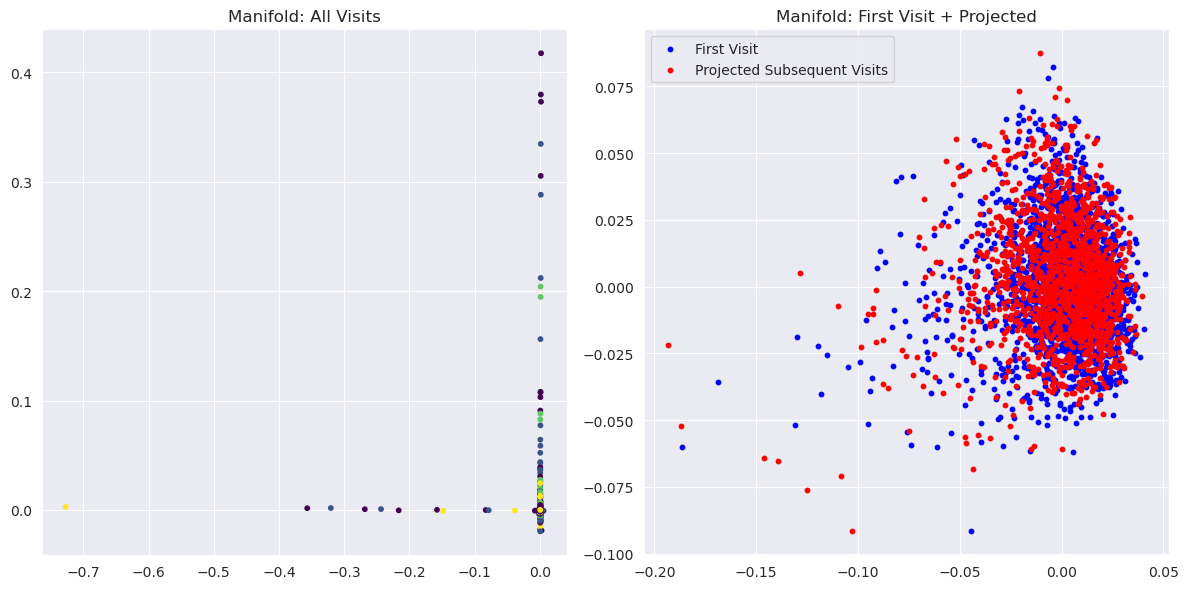

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4410000 and the array at index 1 has size 2735716

In [124]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to generate a manifold
def generate_manifold(data, n_components=2, n_neighbors=50):
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    manifold = lle.fit_transform(data)
    return manifold, lle

# Generate a Manifold using All Visits
manifold_all, lle_all = generate_manifold(SPIROMICS_dataset.loc[:, SPIROMICS_dataset.columns.str.startswith('X')], n_components=3, n_neighbors=15)

# Generate a Manifold using only the First Visit
manifold_first, lle_first = generate_manifold(SPIROMICS_dataset_P1.loc[:, SPIROMICS_dataset_P1.columns.str.startswith('X')], n_components=3, n_neighbors=200)

# Project subsequent visits onto the first visit manifold
SPIROMICS_dataset_subsequent_visits = SPIROMICS_dataset[SPIROMICS_dataset['VISIT'].isin([2])]
projected_subsequent_visits = lle_first.transform(SPIROMICS_dataset_subsequent_visits.loc[:, SPIROMICS_dataset_subsequent_visits.columns.str.startswith('X')])

# Subject IDs for first and subsequent visits
subject_ids_first = SPIROMICS_dataset_P1.index.values
subject_ids_subsequent = SPIROMICS_dataset_subsequent_visits.index.values

# Pairwise distances in the projected manifold
dm_projected = pairwise_distances(projected_subsequent_visits)

# Check if closest points in the projected manifold belong to the same subject
n_neighbors = 5  # Number of neighbors to check
same_subject_count = 0

for i in range(len(projected_subsequent_visits)):
    # Get the closest points in the projected manifold
    neighbors = np.argsort(dm_projected[i])[:n_neighbors]

    # Check how many neighbors belong to the same subject
    same_subject_neighbors = np.sum(subject_ids_subsequent[neighbors] == subject_ids_subsequent[i])
    same_subject_count += same_subject_neighbors

# Calculate the proportion of same-subject neighbors
total_neighbors = len(projected_subsequent_visits) * n_neighbors
same_subject_proportion = same_subject_count / total_neighbors

print(f"Proportion of same-subject neighbors in projected manifold: {same_subject_proportion:.4f}")

# Visualize the two manifolds side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot manifold generated from all visits
axes[0].scatter(manifold_all[:, 0], manifold_all[:, 1], c=SPIROMICS_dataset["VISIT"], cmap="viridis", s=10)
axes[0].set_title("Manifold: All Visits")

# Plot manifold from first visit with projected subsequent visits
axes[1].scatter(manifold_first[:, 0], manifold_first[:, 1], c="blue", label="First Visit", s=10)
axes[1].scatter(projected_subsequent_visits[:, 0], projected_subsequent_visits[:, 1], c="red", label="Projected Subsequent Visits", s=10)
axes[1].set_title("Manifold: First Visit + Projected")
axes[1].legend()

plt.tight_layout()
plt.show()

# Quantitative comparison: Pairwise distance preservation
def compare_distance_matrices(dm1, dm2):
    dm1_flat = dm1.flatten()
    dm2_flat = dm2.flatten()
    correlation = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
    return correlation

# Compute pairwise distance matrices
dm_all = pairwise_distances(manifold_all)
dm_first = pairwise_distances(manifold_first)

# Compare distances
all_vs_first = compare_distance_matrices(dm_all[:len(dm_first), :len(dm_first)], dm_first)
first_vs_projected = compare_distance_matrices(dm_first, dm_projected)

print(f"Distance Correlation (All Visits vs First Visit): {all_vs_first:.4f}")
print(f"Distance Correlation (First Visit vs Projected Subsequent Visits): {first_vs_projected:.4f}")

In [147]:
import pandas as pd

# Read the dataset
SPIROMICS_dataset_C = pd.read_csv('/home/shussein/NetCO/data/SPIROMICS/SPIROMICS_V1V2V4V5_4.csv', index_col=0)
# SPIROMICS_dataset_C.reset_index(inplace=True)

# Ensure data is sorted by SUBJID and VISIT
SPIROMICS_dataset_C = SPIROMICS_dataset_C.sort_values(by=['SUBJID', 'VISIT'])

# Convert phenotype values to a consistent type (e.g., string)
SPIROMICS_dataset_C['GOLD_STAGE_COPD_SEVERITY'] = SPIROMICS_dataset_C['GOLD_STAGE_COPD_SEVERITY'].astype(str)

# Initialize a PhenotypeChange column with False
SPIROMICS_dataset_C['PhenotypeChange'] = False

# Compare rows directly within each subject group
def detect_changes(group):
    # Compare current row with the previous row
    group['PhenotypeChange'] = group['GOLD_STAGE_COPD_SEVERITY'] != group['GOLD_STAGE_COPD_SEVERITY'].iloc[0]
    return group

SPIROMICS_dataset_C = SPIROMICS_dataset_C.groupby('SUBJID').apply(detect_changes)

# Identify subjects with any phenotype change
subjects_with_change = SPIROMICS_dataset_C.groupby('SUBJID')['PhenotypeChange'].any()
print(subjects_with_change)

# Calculate proportion of subjects with phenotype changes
proportion_with_change = subjects_with_change.mean()

print(f"Proportion of subjects with phenotype change: {proportion_with_change:.2%}")

# Inspect the dataset
print(SPIROMICS_dataset_C[['VISIT', 'GOLD_STAGE_COPD_SEVERITY', 'PhenotypeChange']].head(20))

SUBJID
CU100103    False
CU100139    False
CU100228     True
CU100242     True
CU100263     True
            ...  
WF121956     True
WF121991     True
WF122213     True
WF122690     True
WF122736     True
Name: PhenotypeChange, Length: 177, dtype: bool
Proportion of subjects with phenotype change: 36.72%
                      VISIT GOLD_STAGE_COPD_SEVERITY  PhenotypeChange
SUBJID   SUBJID                                                      
CU100103 CU100103  BASELINE                        0            False
         CU100103    VISIT5                        0            False
         CU100103     YEAR1                        0            False
         CU100103     YEAR3                        0            False
CU100139 CU100139  BASELINE                        0            False
         CU100139    VISIT5                        0            False
         CU100139     YEAR1                        0            False
         CU100139     YEAR3                        0            

In [136]:
SPIROMICS_dataset_C.groupby('SUBJID')['GOLD_STAGE_COPD_SEVERITY']